In [16]:
!pip install torch_geometric
!pip install torchviz

In [17]:
import numpy as np
import torch
import torch_geometric
import h5py
import matplotlib.pyplot as plt

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import global_mean_pool
from torch.nn import Linear

In [5]:
Data_Path = '/kaggle/input/paraquet-df/quark-gluon_data-set_n139306.hdf5'
Data_Size = 40000
k = 8

In [6]:
import h5py
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

def load_data(k=8, max_nodes=800, activation_threshold=1e-3):
    # Adding coordinates to the featues.
    data = h5py.File(Data_Path, "r")
    images = data['X_jets'][0:Data_Size]
    coords = np.indices((125, 125))
    coords = np.moveaxis(coords, 1, -1).T
    coords = np.expand_dims(coords, axis=0)
    coords = coords.astype(np.float32) / 125.
    coords = np.repeat(coords, Data_Size, axis=0)

    # Surpressing smaller activations
    images[images < activation_threshold] = 0.0
    images_with_coords = np.concatenate((images, coords), axis=-1)

    del coords
    del images
    del data

    data = images_with_coords.reshape((-1, images_with_coords.shape[1] * images_with_coords.shape[2], 5))
    node_list = []
    for i, x in enumerate(data):
        mask = np.any(x[..., :3] != [0., 0., 0.], axis=-1)
        filtered_nodes = x[mask]
        # canonical ordering of nodes.(sorted positions)
        sorted_nodes = filtered_nodes[np.lexsort((filtered_nodes[:, 4], filtered_nodes[:, 3]))]

        if sorted_nodes.shape[0] > max_nodes:
            sorted_nodes = sorted_nodes[:max_nodes]
        
        node_list.append(sorted_nodes)

    dataset = []
    for i, nodes in enumerate(node_list):
        edges = kneighbors_graph(nodes[..., 3:], k, mode='connectivity', include_self=True)
        c = edges.tocoo()
        edge_list = torch.from_numpy(np.vstack((c.row, c.col))).type(torch.long)
        edge_weight = torch.from_numpy(c.data.reshape(-1, 1))
        data = Data(x=torch.from_numpy(nodes), edge_index=edge_list, edge_attr=edge_weight)
        dataset.append(data)
    
    return dataset


In [68]:
#dataset = load_data()
train_loader = DataLoader(dataset[:36000], batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[36000:36500], batch_size=1, shuffle=False)

In [9]:
from torch_geometric.nn import SAGEConv, GATConv


# Graph level latent Graph Auto Encoder
class GAE(torch.nn.Module):
  def __init__(self, input_embed_dim : int, latent_dim = None, max_nodes : int = 800):
    super(GAE, self).__init__()
    
    self.node_dim = input_embed_dim
    if latent_dim is None:
      self.latent_dim = self.node_dim
    else:
      self.latent_dim = latent_dim
    self.max_nodes = max_nodes
    self.output_size = self.max_nodes * self.node_dim
    
    self.Conv1 = GATConv(self.node_dim, self.latent_dim, heads=1, concat=False)
    self.Conv2 = GATConv(self.latent_dim, 2*self.latent_dim, heads=1, concat=False)
    self.Conv3 = GATConv(2*self.latent_dim, 4*self.latent_dim, heads=1, concat=False)
    self.Conv4 = GATConv(4*self.latent_dim, 8*self.latent_dim, heads=1, concat=False)
    self.lin1 = torch.nn.Linear(8*self.latent_dim, 16*self.latent_dim)
    self.lin2 = torch.nn.Linear(16*self.latent_dim, 32*self.latent_dim)
    self.lin3 = torch.nn.Linear(32*self.latent_dim, int(self.output_size / 2))
    self.lin4 = torch.nn.Linear(int(self.output_size / 2), self.output_size)
    self.p5 = nn.Dropout(p=0.5)
    self.p3 = nn.Dropout(p=0.3)
    self.p1 = nn.Dropout(p=0.1)
    

  def forward(self, x, edge_index, batch):
    
    # Encoder.
    x = F.relu(self.Conv1(x, edge_index))
    x = F.relu(self.Conv2(x, edge_index))
    x = F.relu(self.Conv3(x, edge_index))
    x = F.relu(self.Conv4(x, edge_index))

    # mask generation and pooling.
    x, mask = torch_geometric.utils.to_dense_batch(x, batch, fill_value=0)
    x = torch.mean(x, dim=1)

    # Decoder  
    x = F.relu(self.lin1(x))
    x = self.p1(x)
    x = F.relu(self.lin2(x))
    x = self.p1(x)
    x = F.relu(self.lin3(x))
    x = self.lin4(x)
    x = torch.reshape(x, (-1, self.max_nodes, self.node_dim))
    new_mask = torch.zeros(mask.shape[0], self.max_nodes, dtype=torch.bool)
    new_mask[:, :mask.shape[1]] = mask
    mask = new_mask
    
    return x, mask

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)

def reconstruct_image(features):
    x_coords = (features[:, -2] * 125).cpu().numpy().astype(int)
    y_coords = (features[:, -1] * 125).cpu().numpy().astype(int)
    tracks_act = features[:, 0].cpu().numpy()
    ecal_act = features[:, 1].cpu().numpy()
    hcal_act = features[:, 2].cpu().numpy()

    img_tracks = np.zeros((125, 125))
    img_ecal = np.zeros((125, 125))
    img_hcal = np.zeros((125, 125))

    for i in range(len(x_coords)):
        if 0 <= x_coords[i] < 125 and 0 <= y_coords[i] < 125:
            img_tracks[y_coords[i], x_coords[i]] = tracks_act[i]
            img_ecal[y_coords[i], x_coords[i]] = ecal_act[i]
            img_hcal[y_coords[i], x_coords[i]] = hcal_act[i]

    # Stack the channels to get a 3-channel image
    image = np.stack([img_tracks, img_ecal, img_hcal], axis=0)
    return torch.tensor(image, dtype=torch.float32).unsqueeze(0) / np.max(image)
    
def calculate_ssim(data, x):
    original_image = reconstruct_image(data)
    reconstructed_image = reconstruct_image(x)

    # Ensure both images are in the correct format
    original_image = original_image.clamp(0, 1)
    reconstructed_image = reconstructed_image.clamp(0, 1)

    ssim_score = ssim_metric(reconstructed_image, original_image)
    return ssim_score.item()

In [27]:
# Graph features based reconstruction loss.
def weighted_mse_loss(output, target, mask): 
    weights = torch.tensor([1.0, 1.0, 1.0], device=output.device)
    squared_error = (output - target) ** 2
    for i in range(0, 3):
        squared_error[:,:,i] = squared_error[:,:,i] * weights[i]
    # Apply mask to the loss
    masked_error = squared_error * mask.unsqueeze(-1).to(device)
    loss = masked_error.sum() / ((mask.sum() * 5 )+ 1e-8)  # Prevent division by zero
    return loss

In [28]:
def visualize(data):
    x = data[:,3]
    y = data[:,4]
    tracks_act = data[:,0]
    hcal_act = data[:,2]
    ecal_act = data[:,1]
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[0].set_ylim(0, 1)
    # Plot tracks_act
    axs[0].scatter(x, y, c=tracks_act, s= torch.abs(tracks_act) * 500, cmap='inferno', alpha=0.5)
    axs[0].set_title('Tracks Activity')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')

    axs[1].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[1].set_ylim(0, 1)
    # Plot ecal_act
    axs[1].scatter(x, y,  c=ecal_act, s= torch.abs(ecal_act) * 500, cmap='inferno', alpha=0.5)
    axs[1].set_title('Ecal Activity')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')

    axs[2].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[2].set_ylim(0, 1)
    # Plot hcal_act
    axs[2].scatter(x, y, c=hcal_act, s= torch.abs(hcal_act) * 500, cmap='inferno', alpha=0.5)
    axs[2].set_title('Hcal Activity')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')


    plt.tight_layout()
    plt.show()

In [29]:
from tqdm import tqdm
# Training loop.
def train():
    model.train()
    total_loss = 0

    with tqdm(train_loader, desc="Training", leave=False) as t:
        temp_loss = 0
        for data in t:
            data = data.to(device)
            out, mask = model(data.x, data.edge_index, data.batch)
            x,_ = torch_geometric.utils.to_dense_batch(data.x, data.batch, fill_value=0)
            # Mask padding and loss calculation.
            pad_size = model.max_nodes - x.shape[1]
            if (pad_size > 0):
                x = F.pad(x, (0, 0, 0, pad_size, 0, 0))
            loss = weighted_mse_loss(out, x, mask)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            t.set_postfix(loss=loss.item())
        total_loss += temp_loss / 64. # batch_size
    return total_loss / len(train_loader)  # number of batches

In [35]:
# Inference and validation loop.
def inference(model, data_loader, device, vis = False):
    model.eval()
    loss = 0. 
    with torch.no_grad():
        with tqdm(data_loader, desc="Inference", leave=False) as t:
            for data in t:
                data = data.to(device)
                out, mask = model(data.x, data.edge_index, data.batch)
                # Convert input to dense and pad if necessary
                x, _ = torch_geometric.utils.to_dense_batch(data.x, data.batch, fill_value=0)
                # Generate visualizations.
                if (vis):
                    visualize(x[0].cpu())
                    visualize(out[0][:data.x.shape[0]].cpu())
                    ssim_score = calculate_ssim(data.x, out[0][:data.x.shape[0]])
                    print(f"SSIM Score: {ssim_score}")
                pad_size = model.max_nodes - x.shape[1]
                if (pad_size > 0):
                    x = F.pad(x, (0, 0, 0, pad_size, 0, 0))
                loss += weighted_mse_loss(out, x, mask).item()
                
    return loss / len(data_loader)

Epoch :  1  Train Loss :  0.011057700763322532  Val Loss :  0.011028019478544593


Epoch :  2  Train Loss :  0.009681786243434909  Val Loss :  0.013218925567343831


Epoch :  3  Train Loss :  0.009481961878602183  Val Loss :  0.009621655801311135


Epoch :  4  Train Loss :  0.00945135609281529  Val Loss :  0.011157069820910692


Epoch :  5  Train Loss :  0.009359213483038475  Val Loss :  0.010025429306551814


Epoch :  6  Train Loss :  0.009265957575549452  Val Loss :  0.010447329841554165


Epoch :  7  Train Loss :  0.009272608742263452  Val Loss :  0.009542359854094684


Epoch :  8  Train Loss :  0.009084289726432326  Val Loss :  0.009346499224193394


Epoch :  9  Train Loss :  0.009021497163656921  Val Loss :  0.009343842626549304


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                         

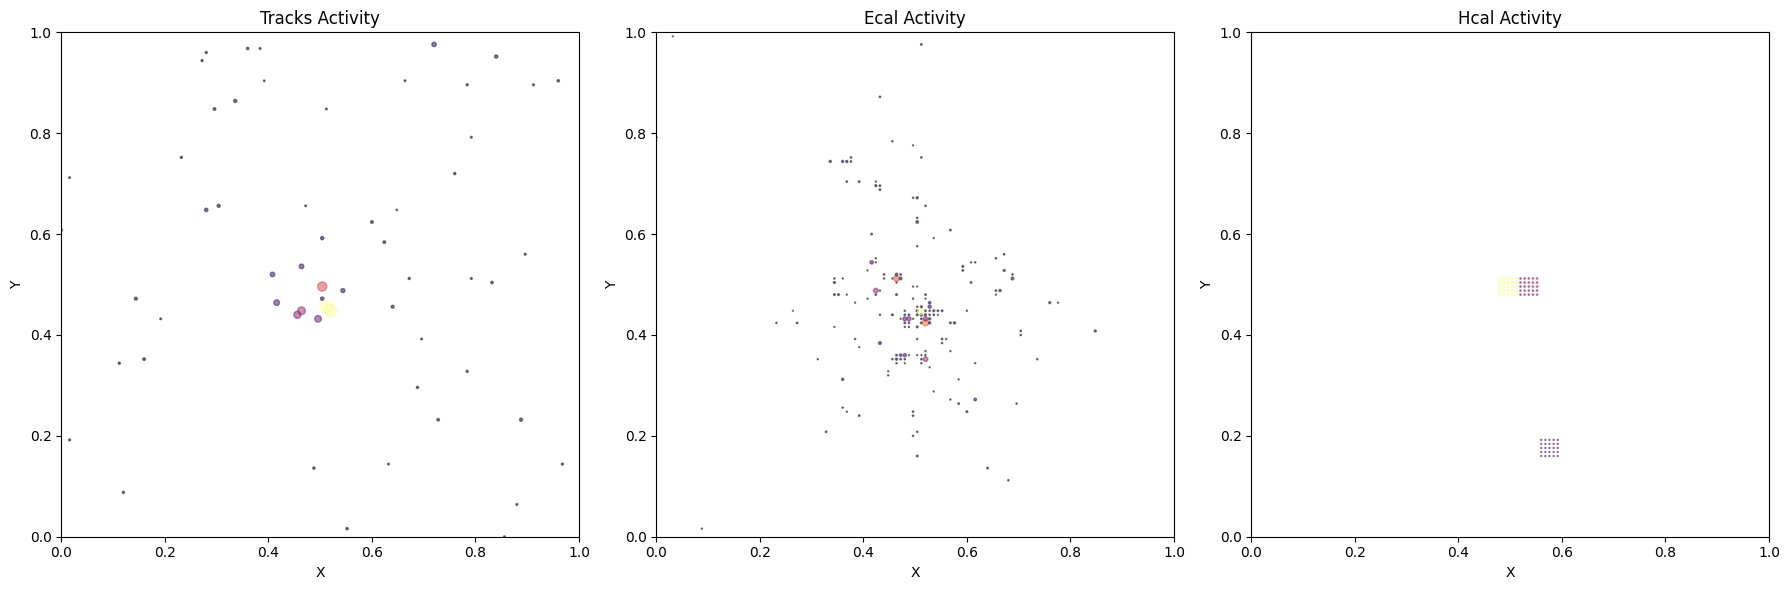

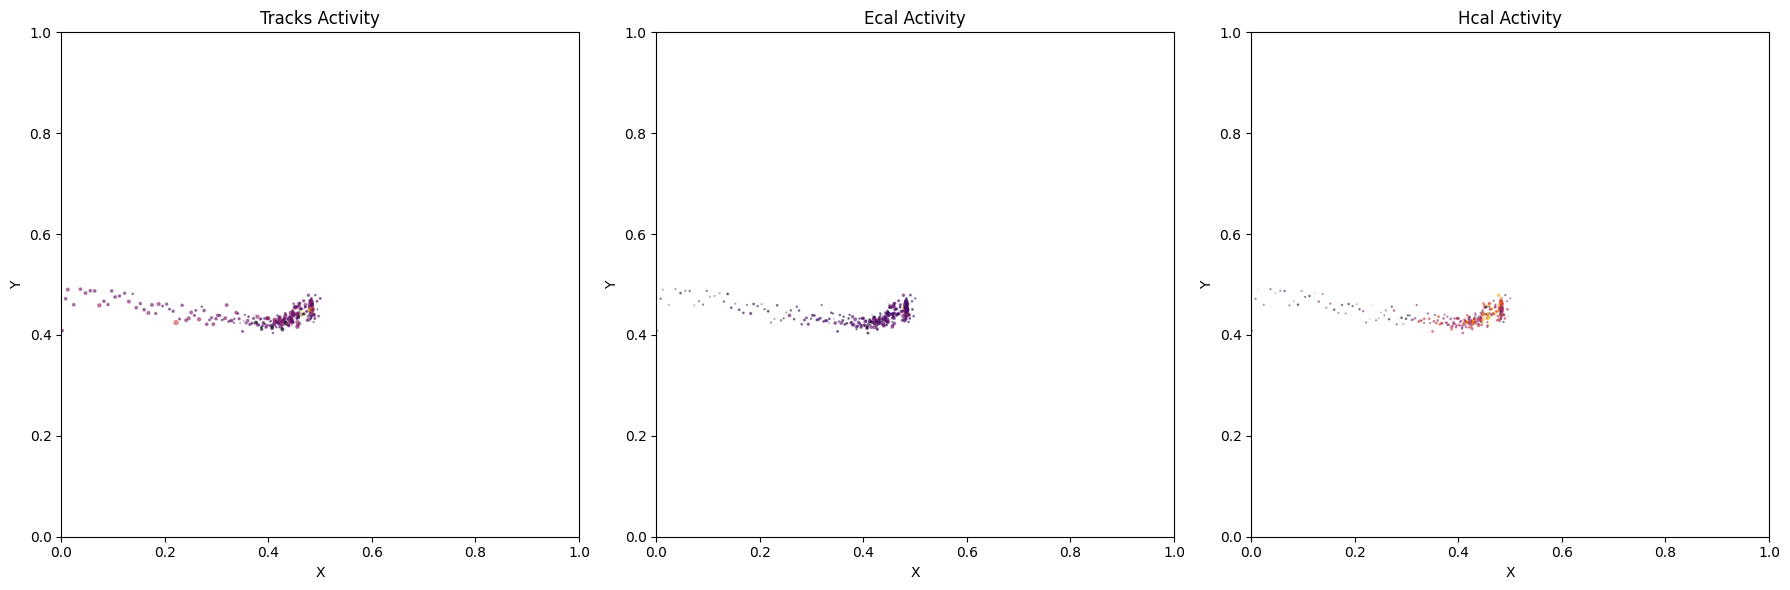

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.05s/it]

SSIM Score: 0.9599383473396301


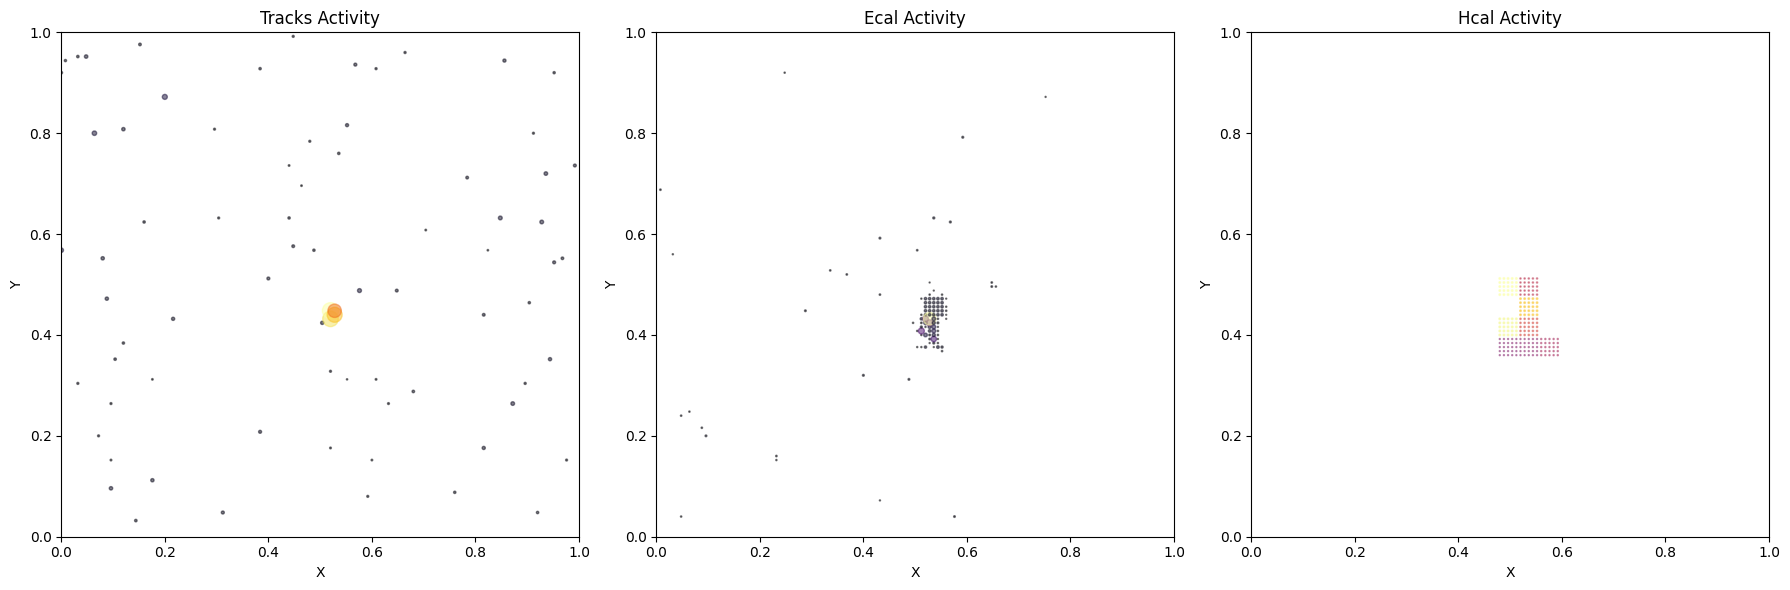

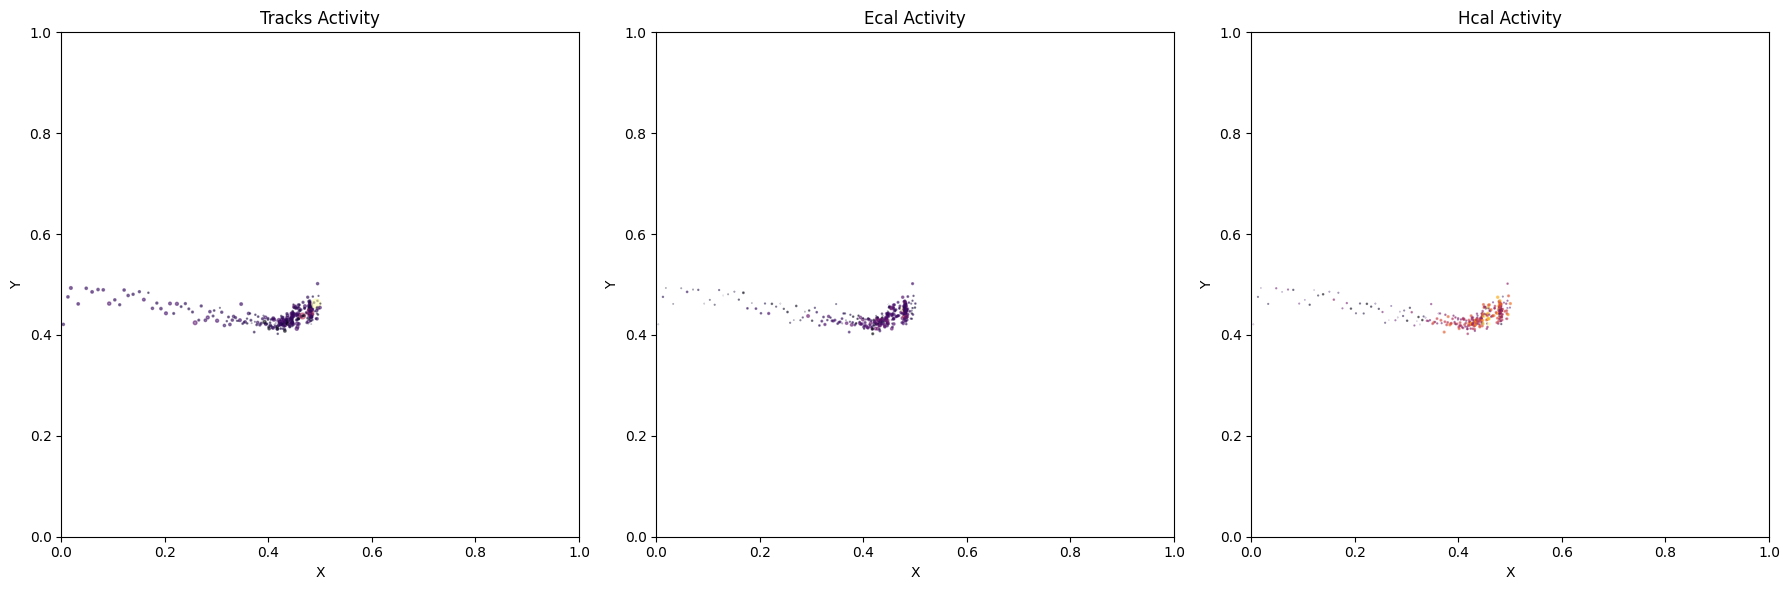

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.03s/it]

SSIM Score: 0.9795094132423401


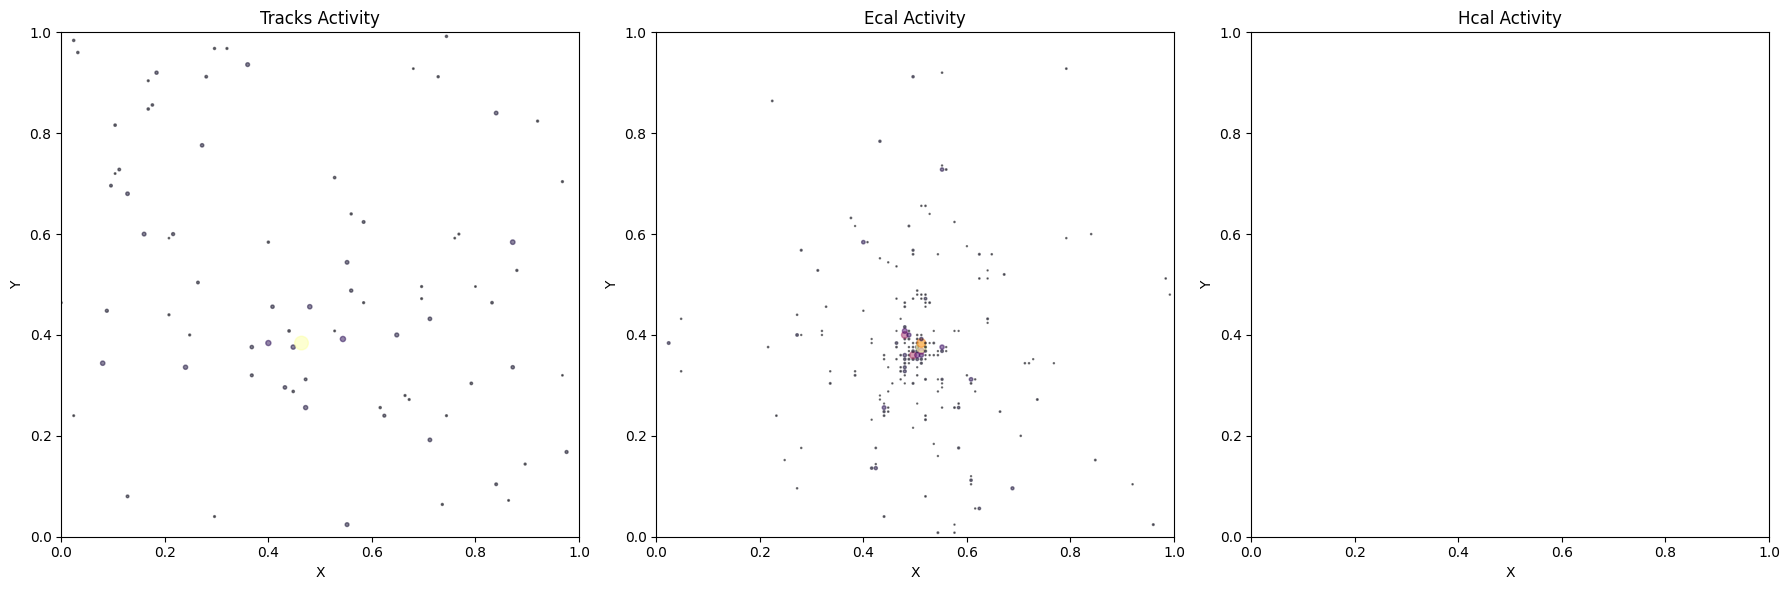

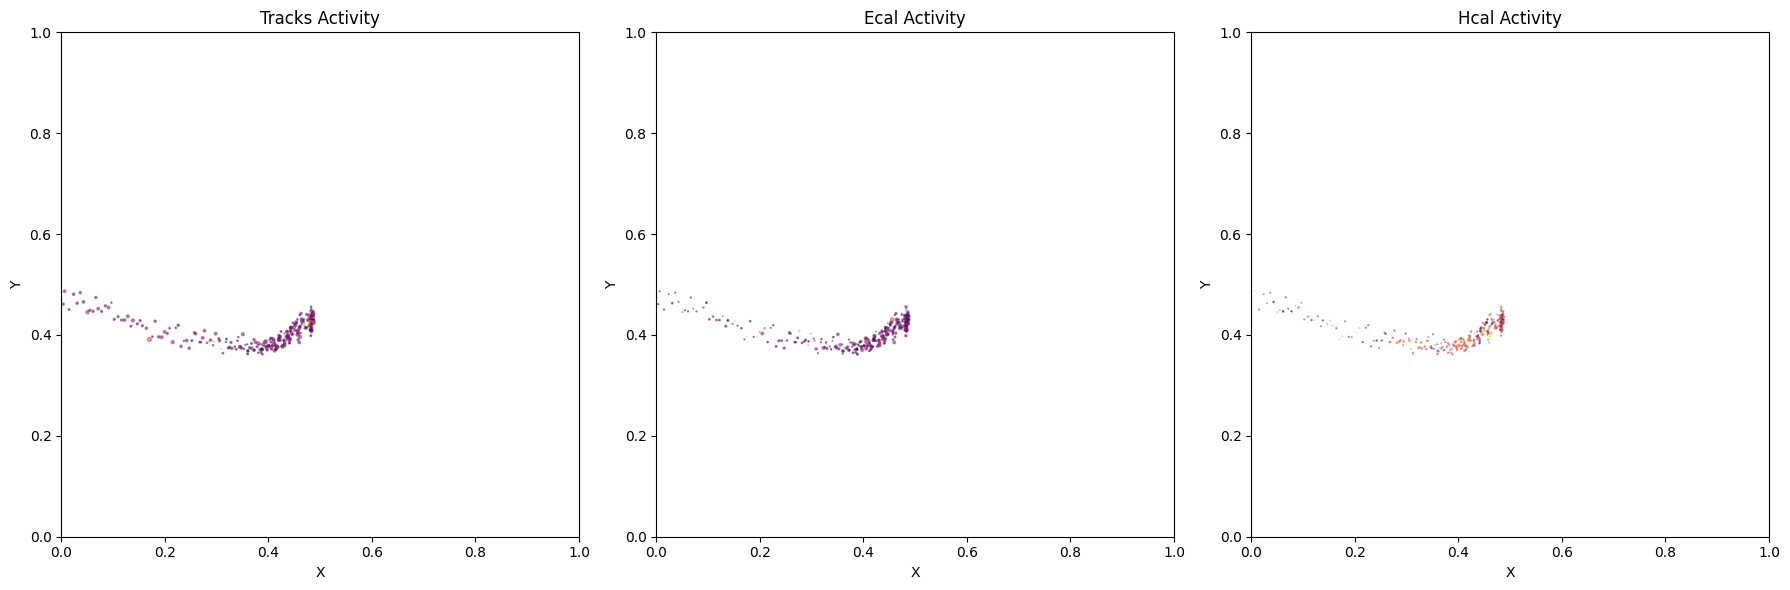

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.23s/it]

SSIM Score: 0.9687685966491699


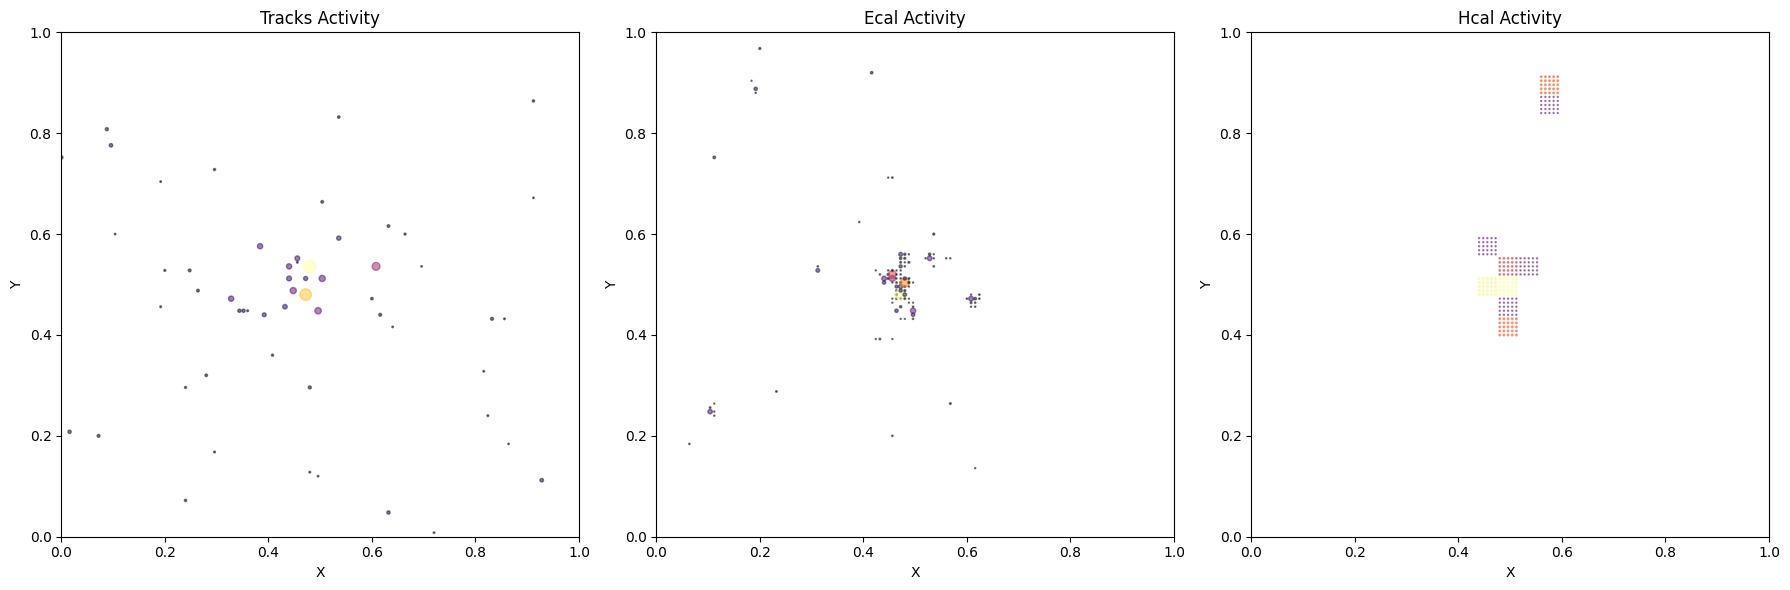

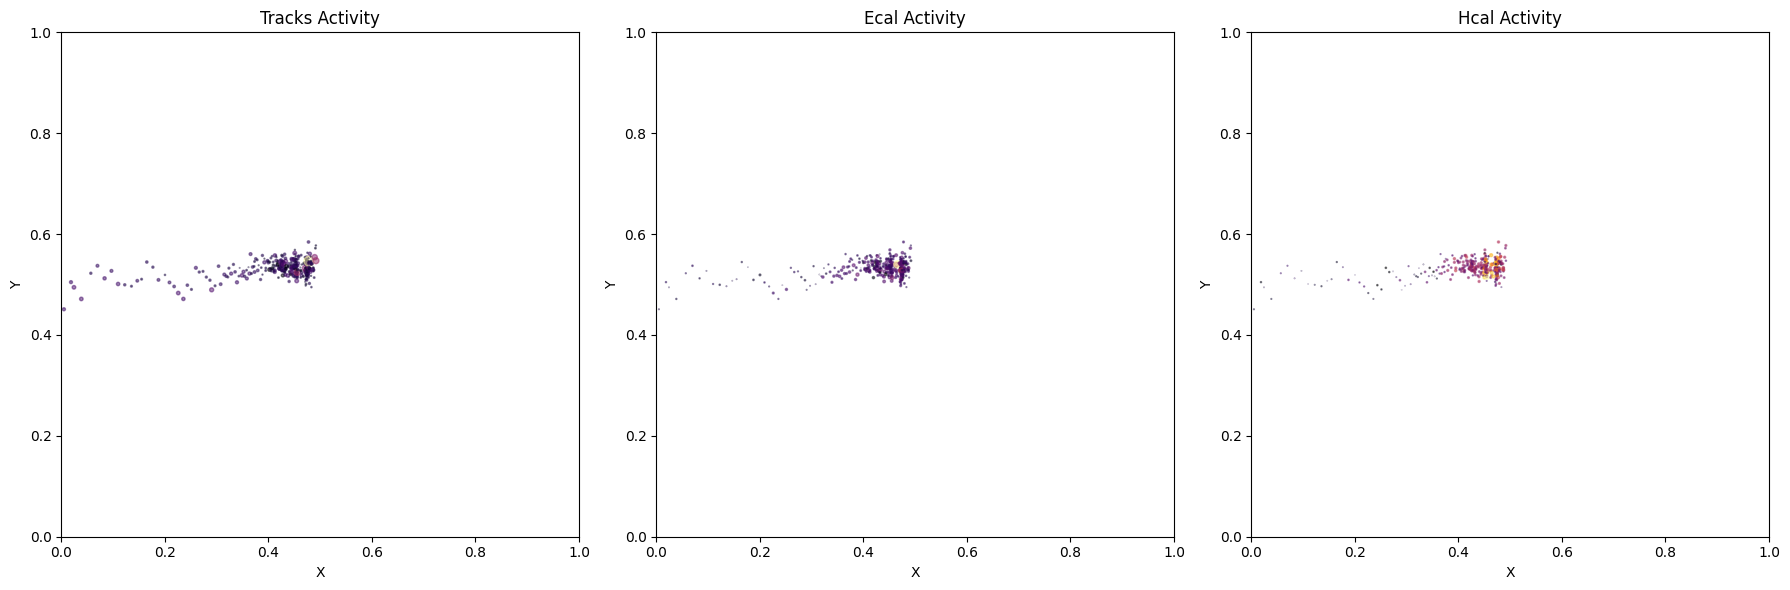

SSIM Score: 0.9654818177223206
Epoch :  10  Train Loss :  0.008994988630629983  Val Loss :  0.010450502159073949


Epoch :  11  Train Loss :  0.008929351400120803  Val Loss :  0.010678368853405118


Epoch :  12  Train Loss :  0.008901529056293026  Val Loss :  0.01010836276691407


Epoch :  13  Train Loss :  0.008906047820191347  Val Loss :  0.009127994417212903


Epoch :  14  Train Loss :  0.008947819495345358  Val Loss :  0.00971486559137702


Epoch :  15  Train Loss :  0.00887957946719936  Val Loss :  0.009875562856905162


Epoch :  16  Train Loss :  0.008787396745210377  Val Loss :  0.009927683626301587


Epoch :  17  Train Loss :  0.008780649725883723  Val Loss :  0.009619026212021708


Epoch :  18  Train Loss :  0.008720445104247724  Val Loss :  0.009117868961766362


Epoch :  19  Train Loss :  0.008744694974081554  Val Loss :  0.009707177756354213


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                         

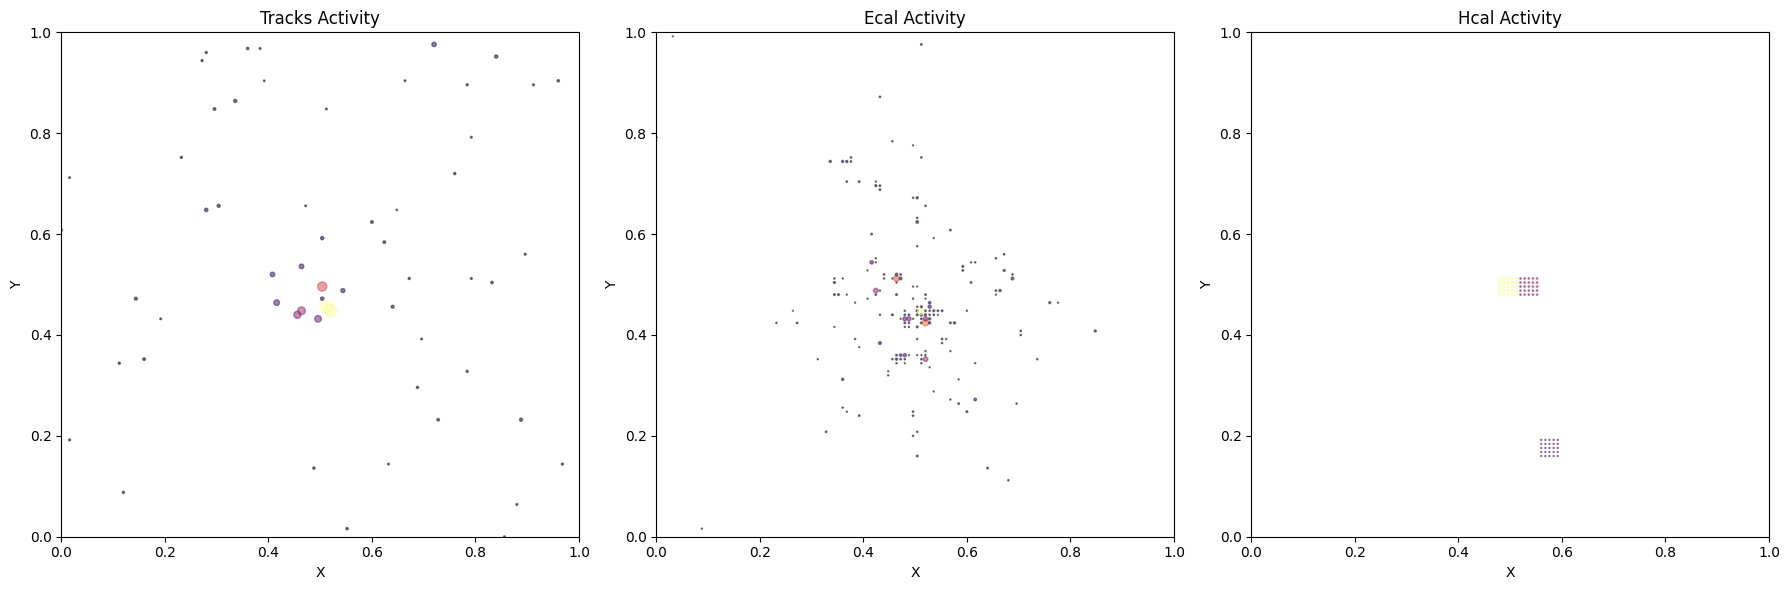

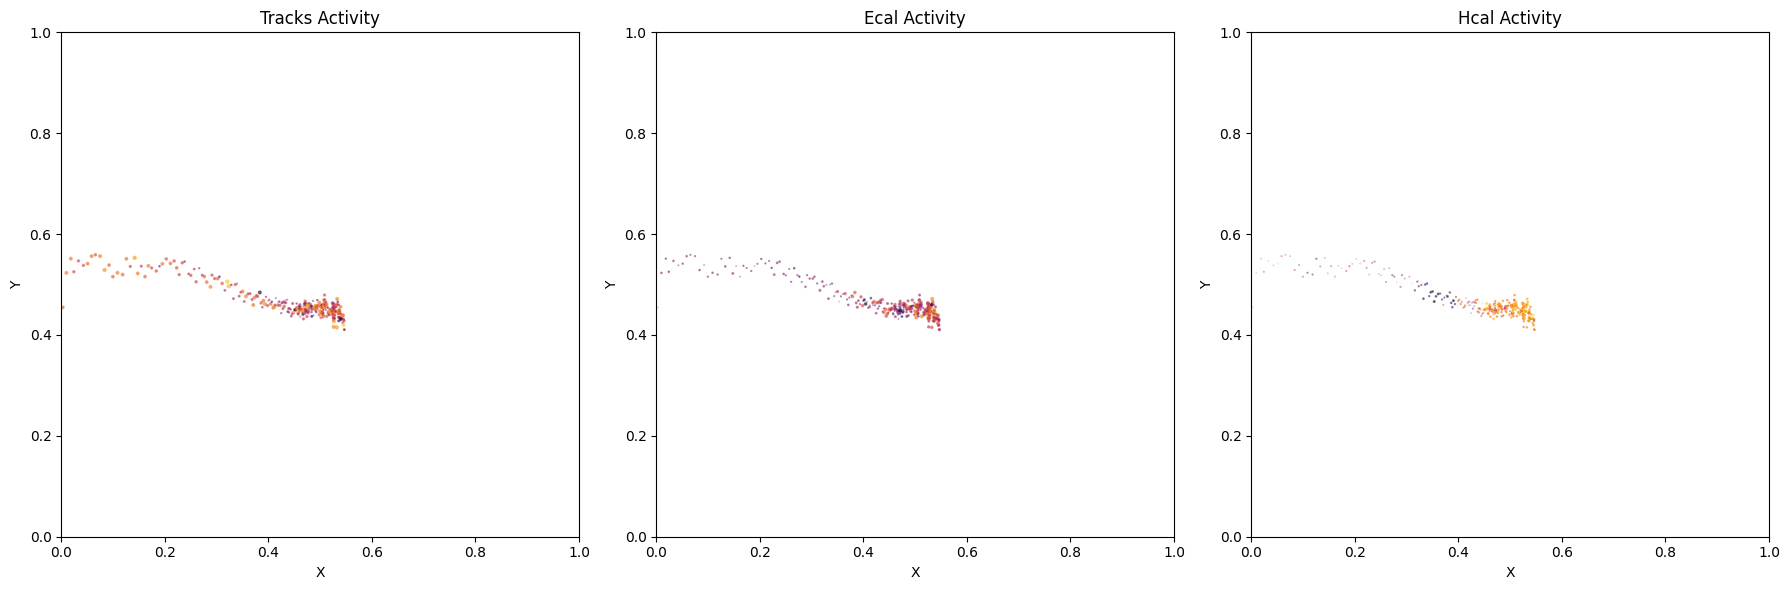

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.04s/it]

SSIM Score: 0.9573631882667542


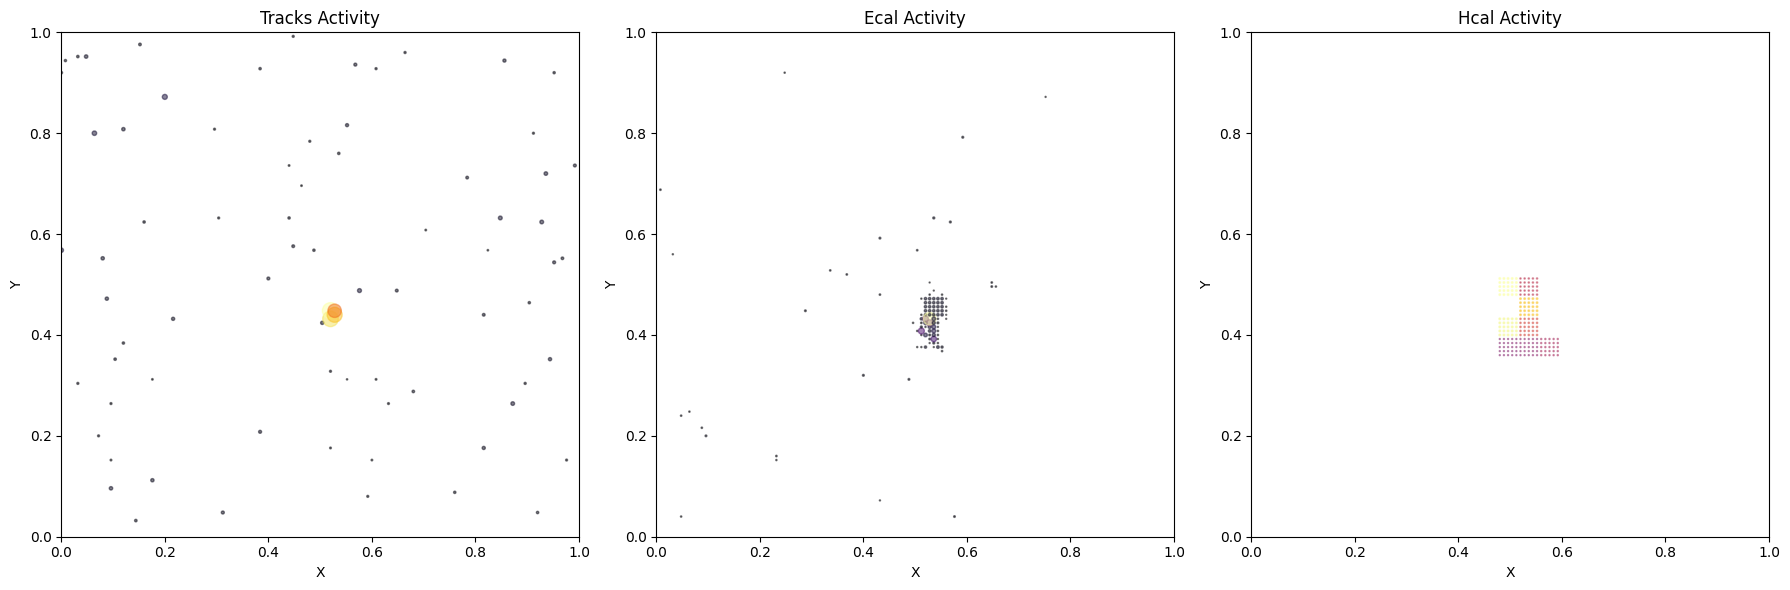

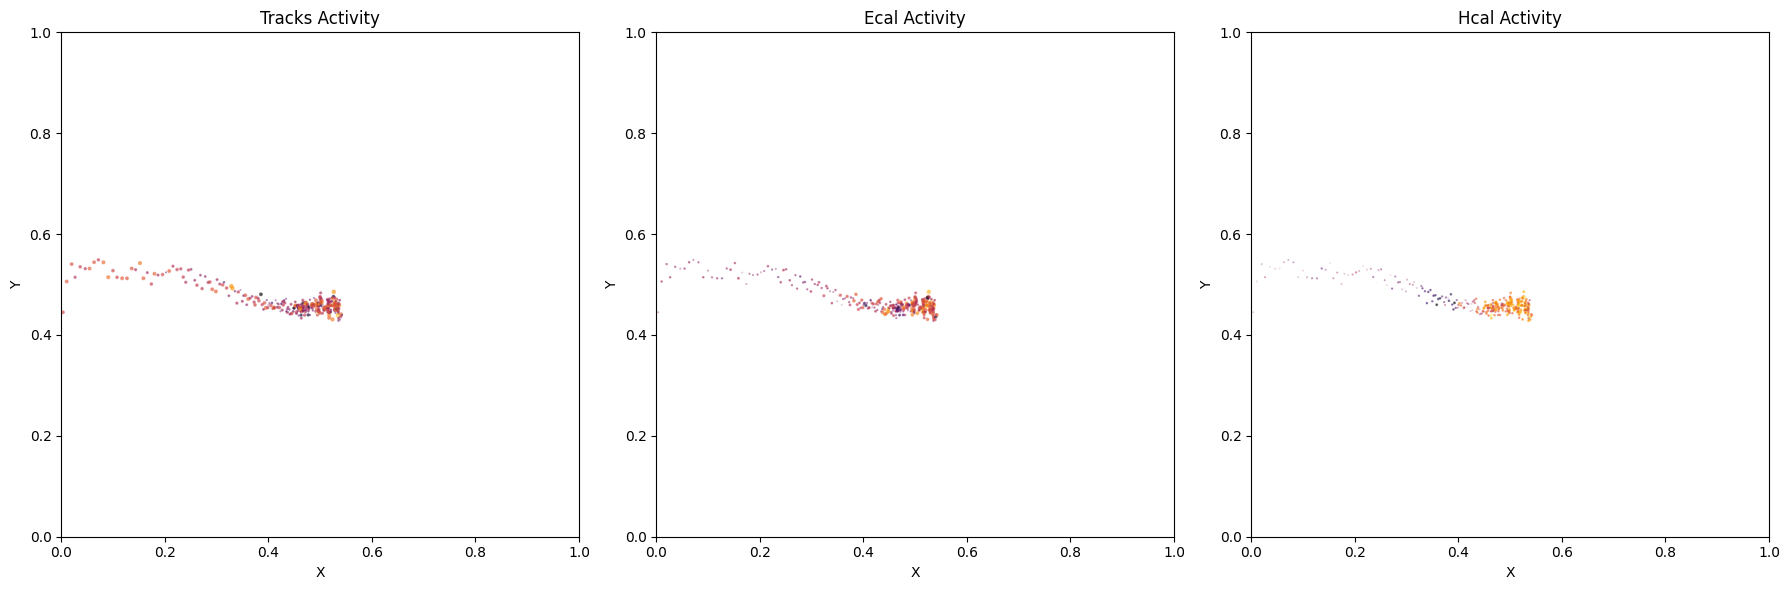

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.03s/it]

SSIM Score: 0.96088707447052


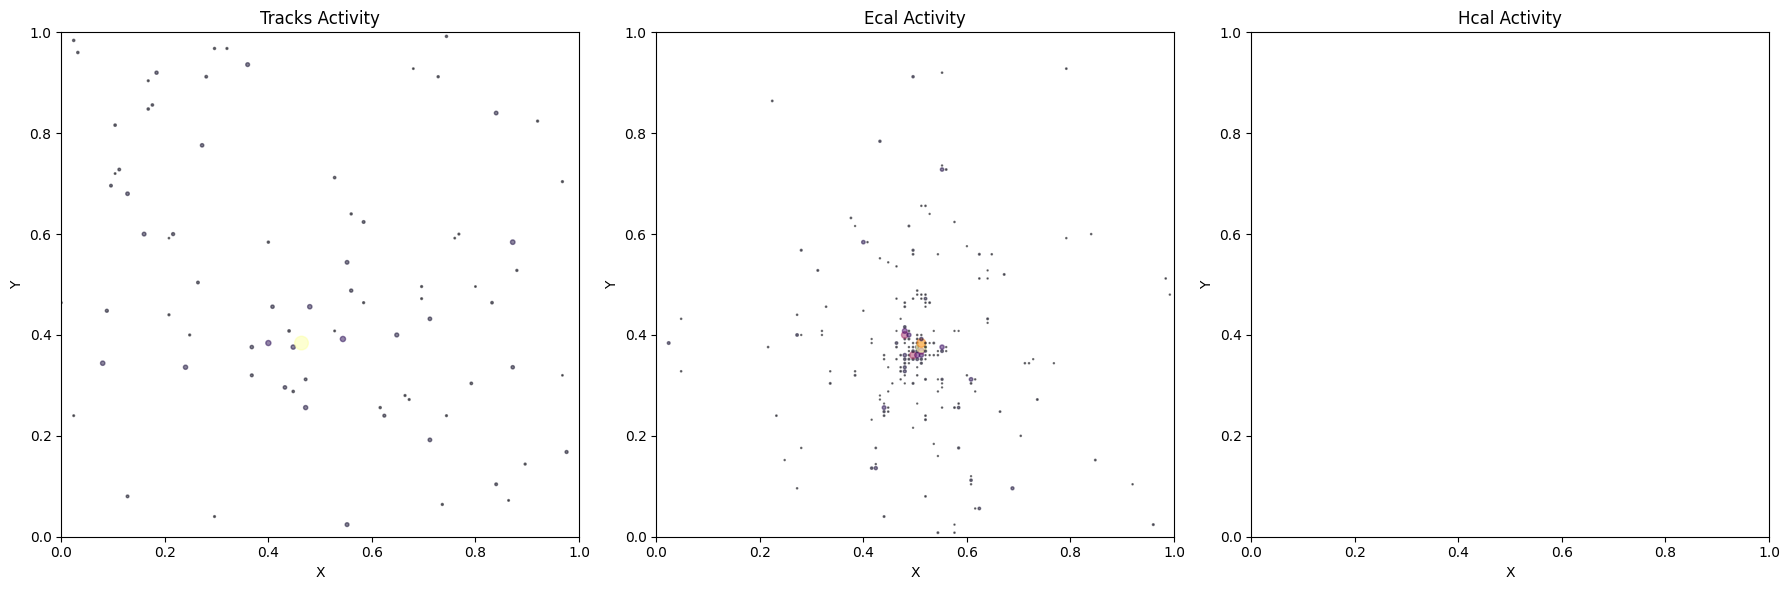

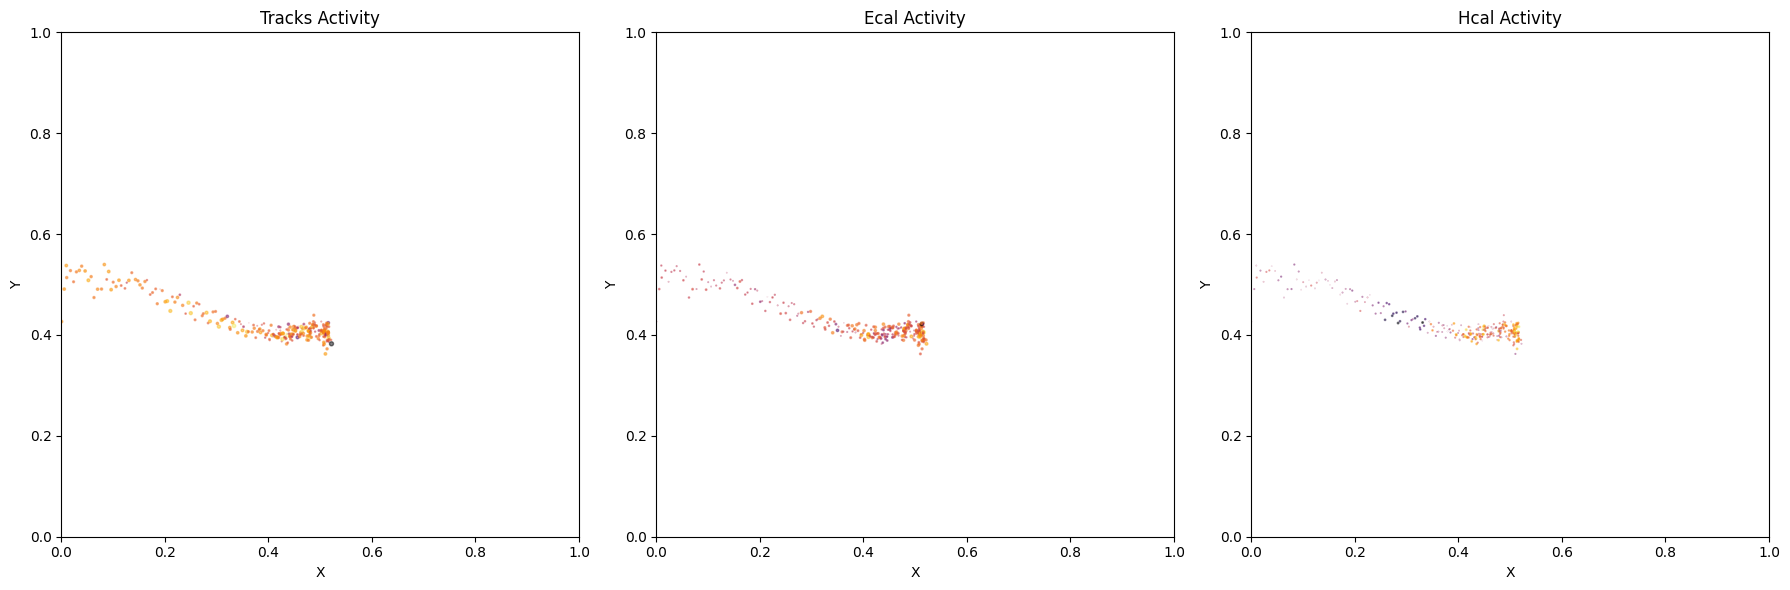

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.00s/it]

SSIM Score: 0.9580322504043579


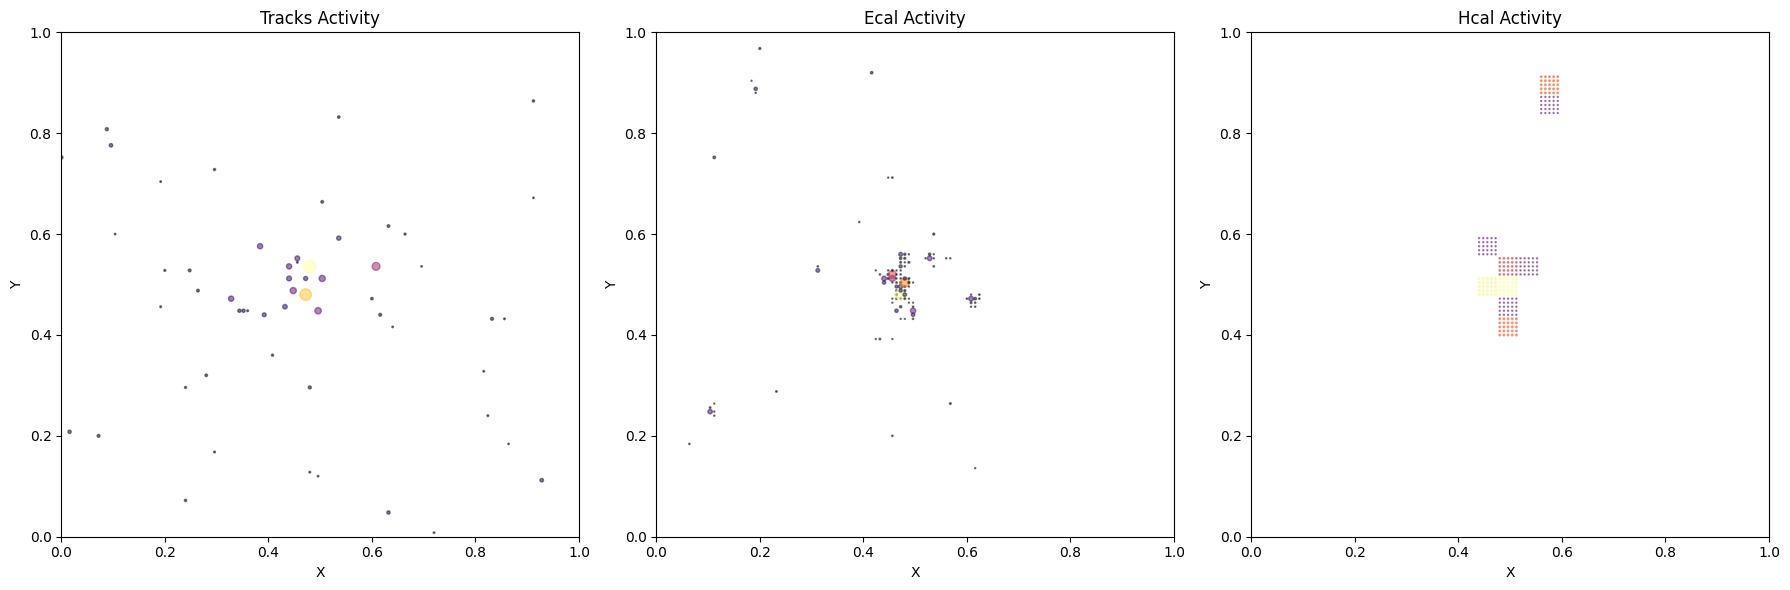

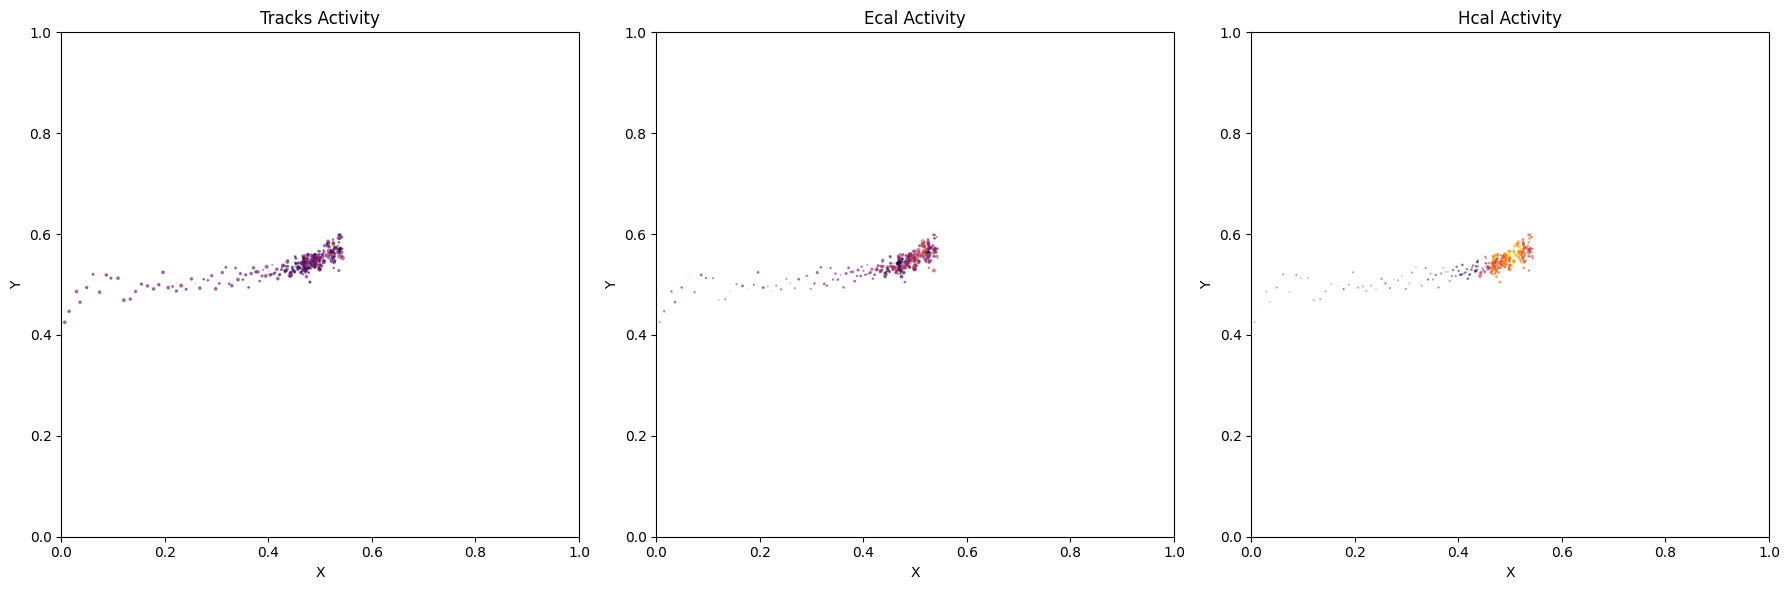

SSIM Score: 0.9638659358024597
Epoch :  20  Train Loss :  0.008736778385639455  Val Loss :  0.00918939197435975


Epoch :  21  Train Loss :  0.008692319047526452  Val Loss :  0.009900415199808776


Epoch :  22  Train Loss :  0.008650521112549686  Val Loss :  0.009183650487102568


Epoch :  23  Train Loss :  0.008670025537382699  Val Loss :  0.009176626452244818


Epoch :  24  Train Loss :  0.008634347900364474  Val Loss :  0.009426713455468416


Epoch :  25  Train Loss :  0.008688366285411121  Val Loss :  0.008845760952681303


Epoch :  26  Train Loss :  0.008635075004410733  Val Loss :  0.008883912465535104


Epoch :  27  Train Loss :  0.008611272770719566  Val Loss :  0.00970402848906815


Epoch :  28  Train Loss :  0.008589943334109566  Val Loss :  0.010046445298939943


Epoch :  29  Train Loss :  0.008601670426384381  Val Loss :  0.008998936624266207


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                         

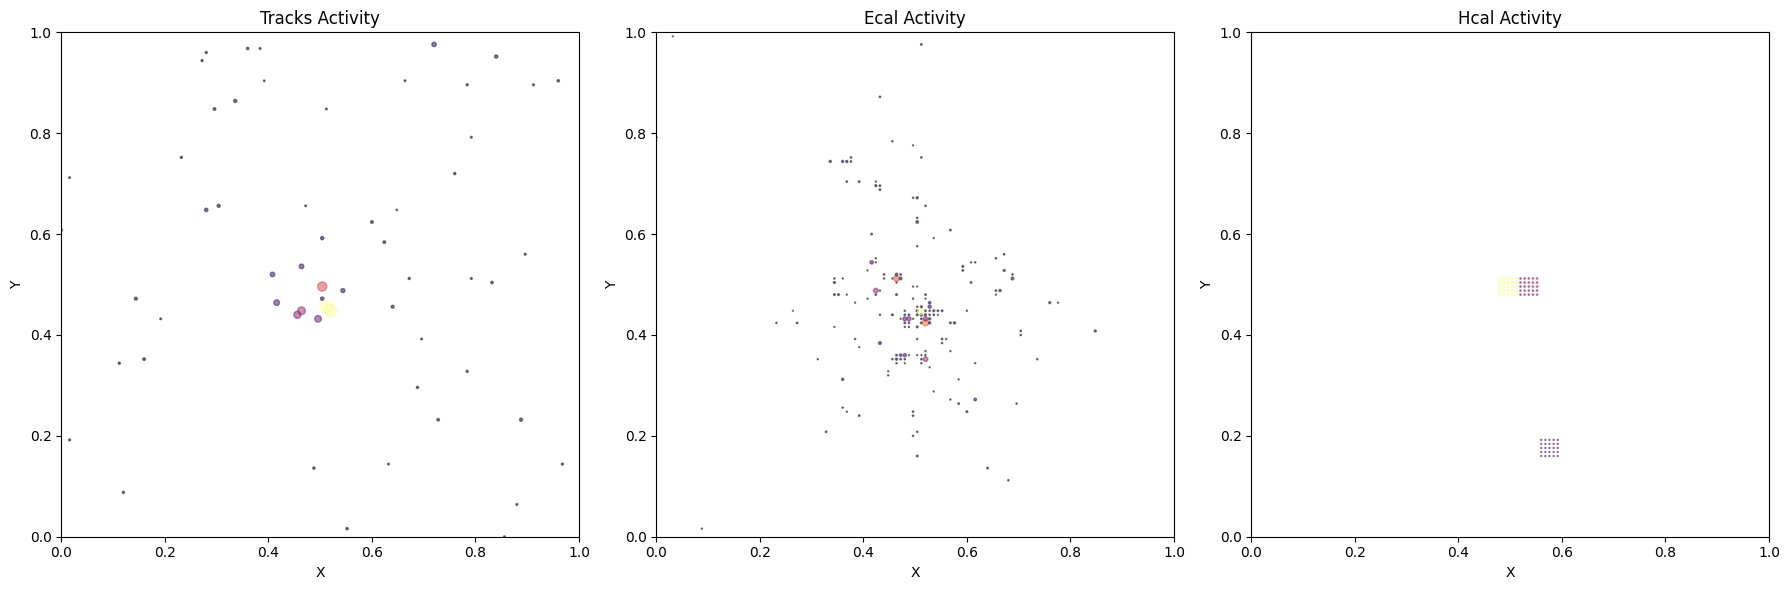

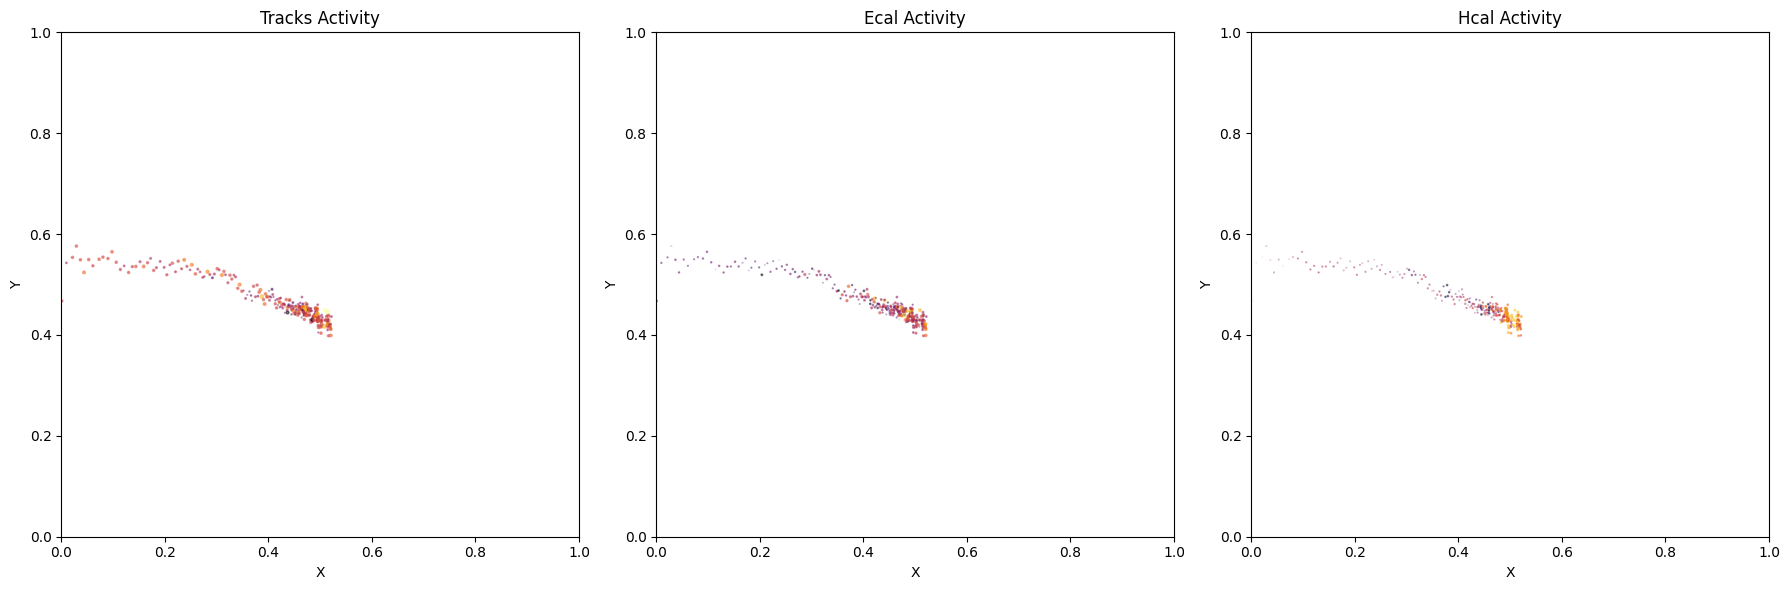

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.03s/it]

SSIM Score: 0.9595366716384888


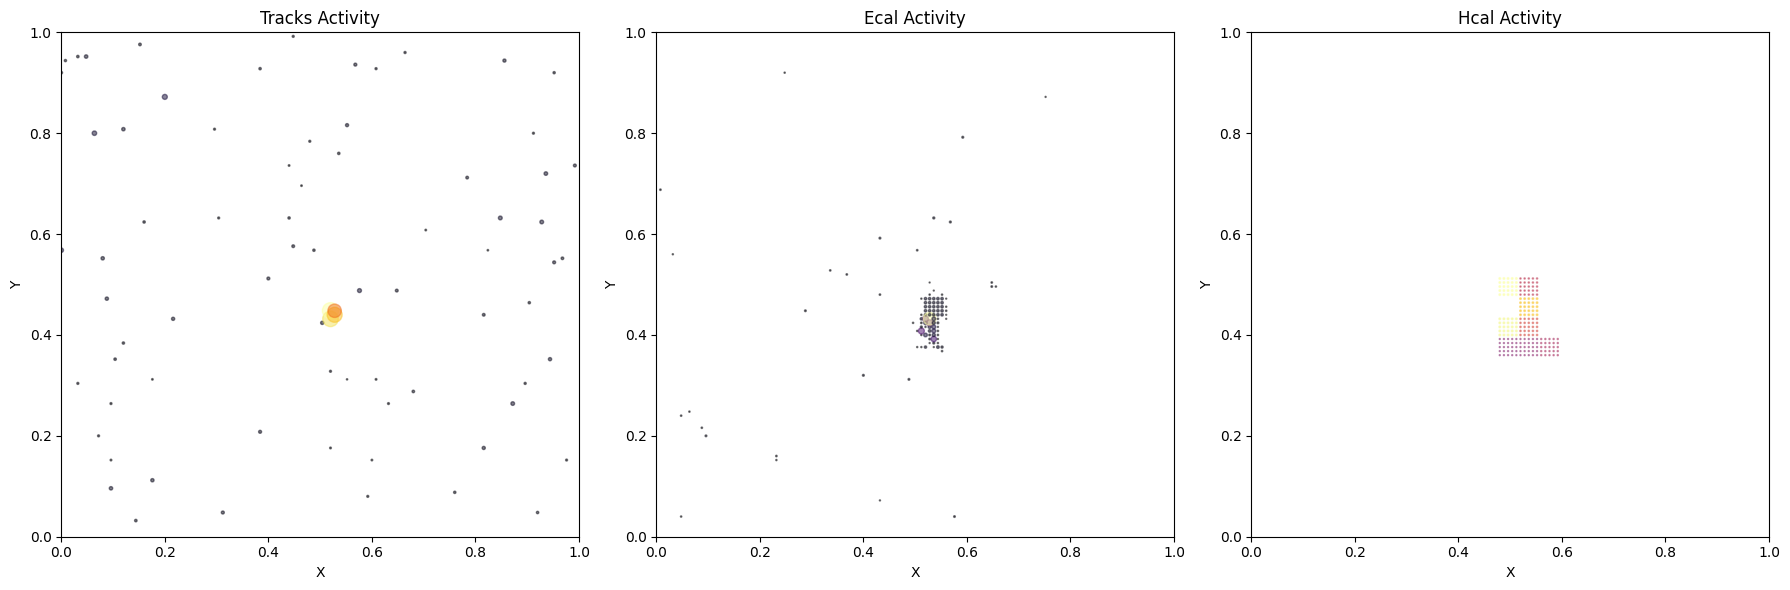

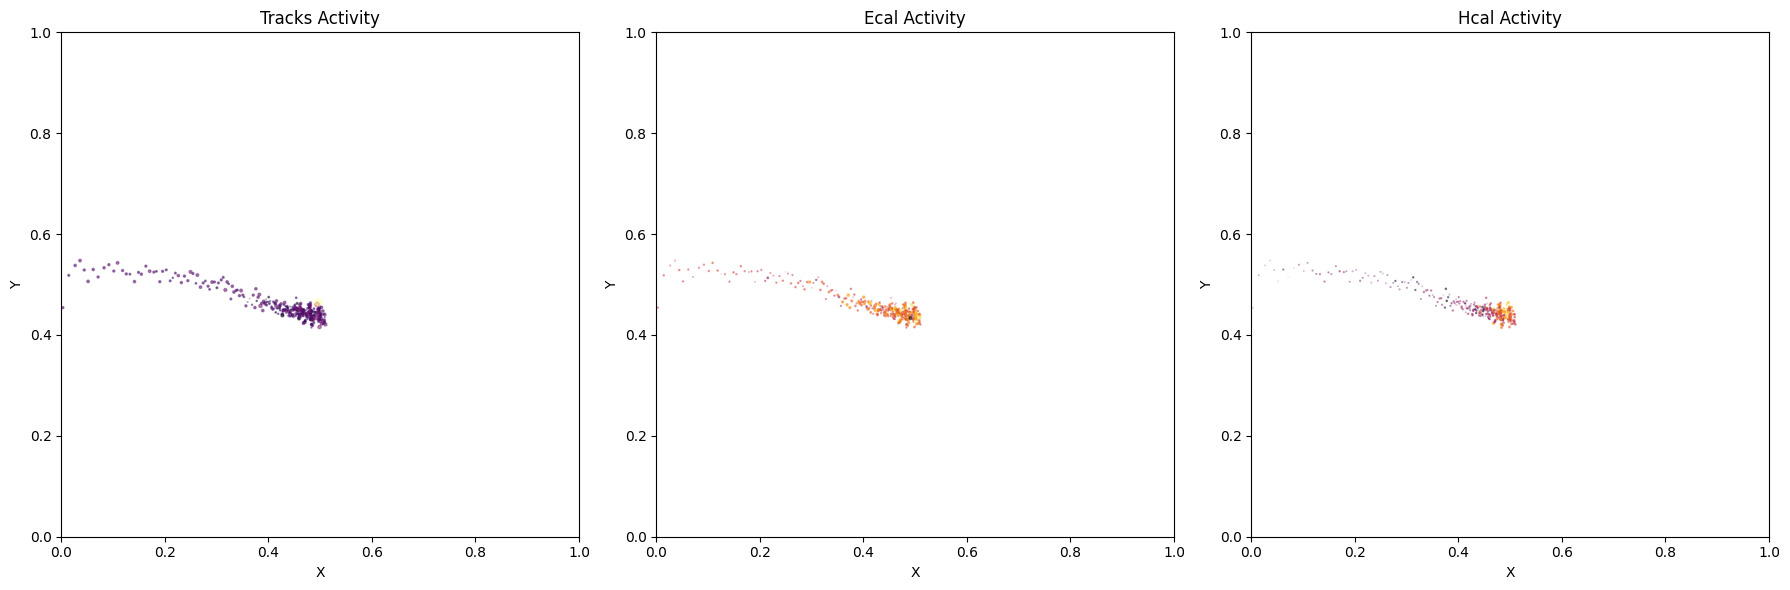

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.02s/it]

SSIM Score: 0.9767847657203674


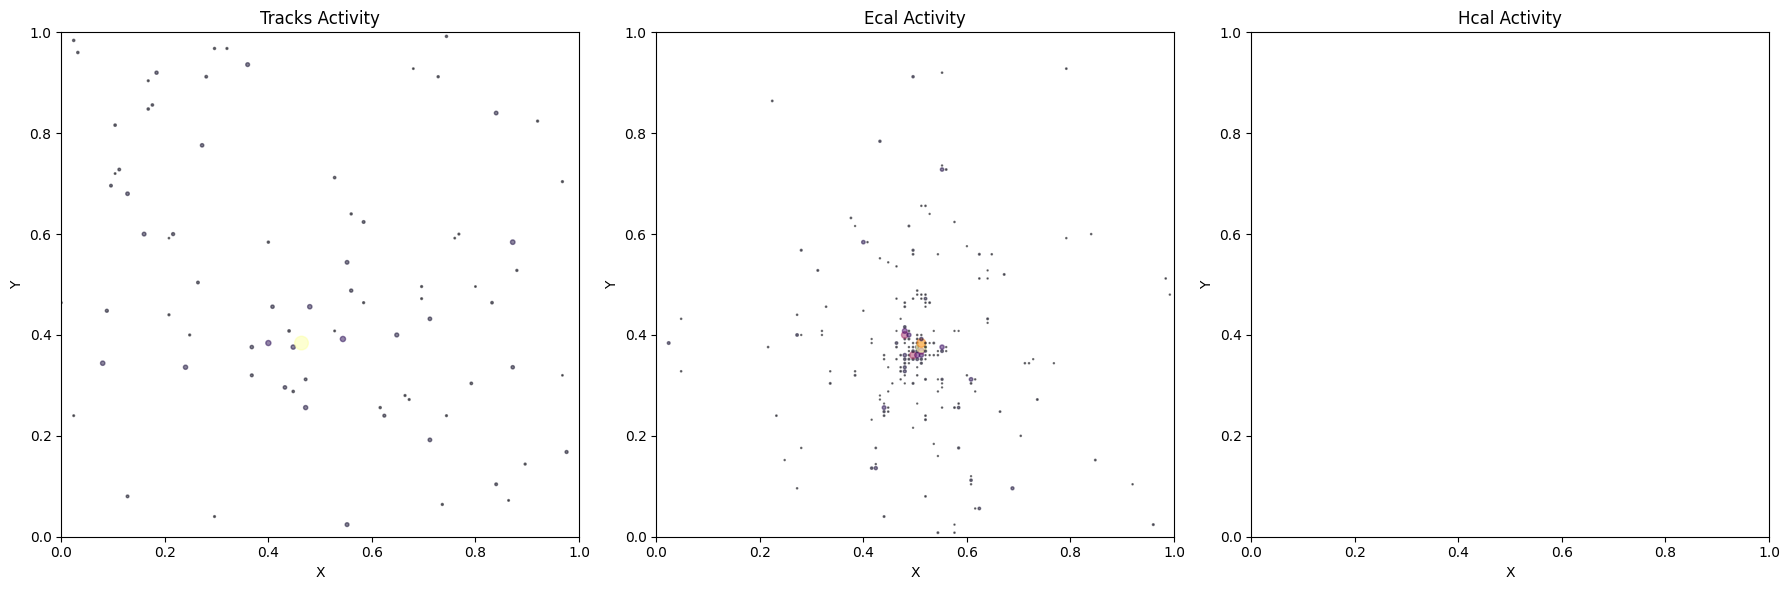

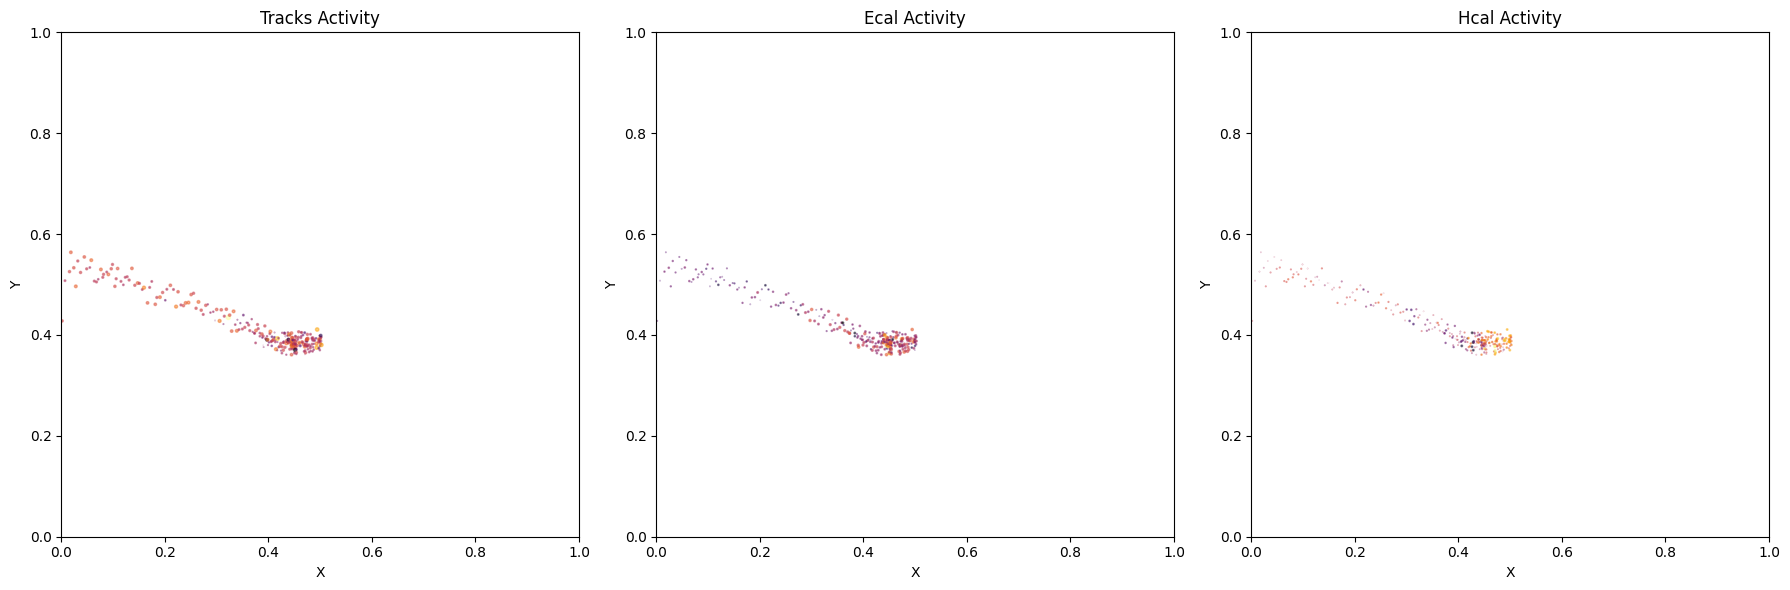

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.02s/it]

SSIM Score: 0.9558960199356079


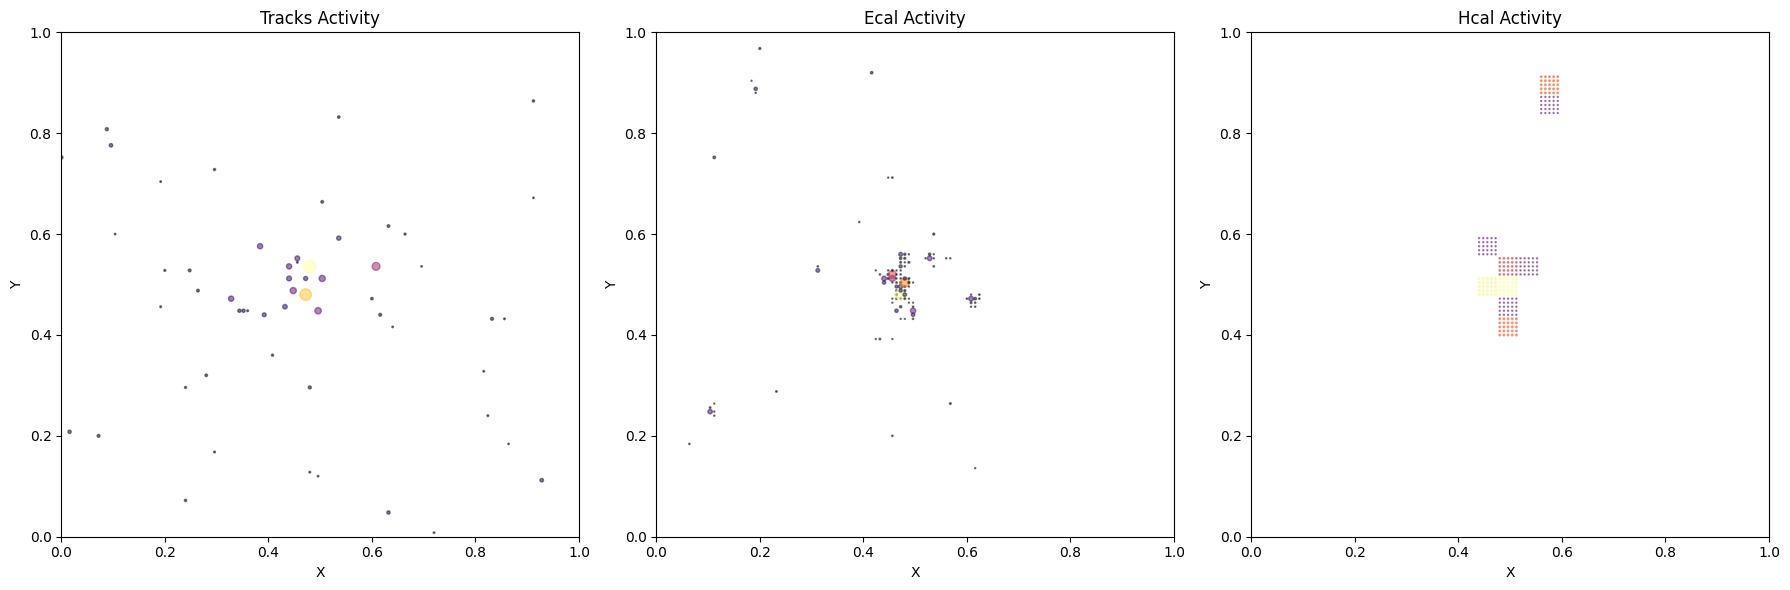

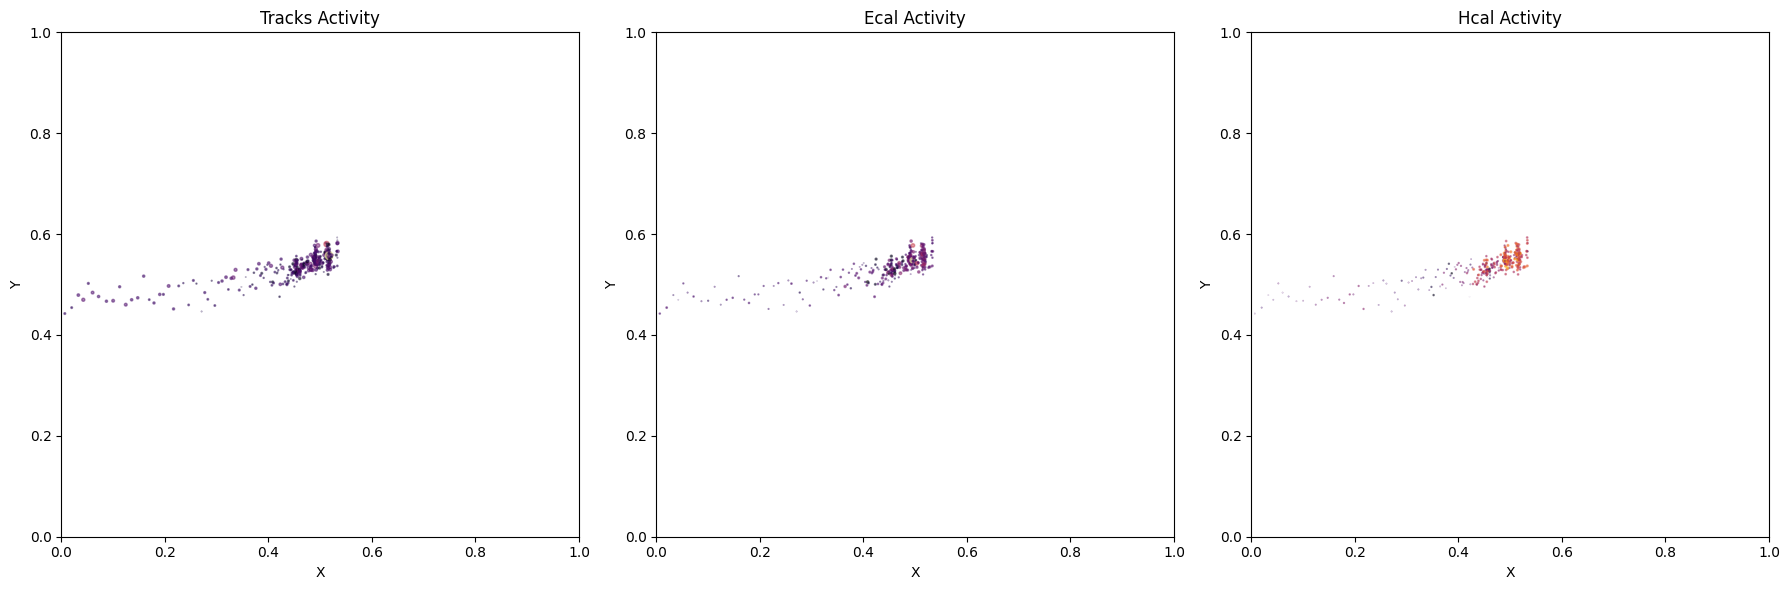

SSIM Score: 0.9662761092185974
Epoch :  30  Train Loss :  0.008628227656167893  Val Loss :  0.009777276078239083


Epoch :  31  Train Loss :  0.008558325271815274  Val Loss :  0.009466765564866364


Epoch :  32  Train Loss :  0.008548969789168286  Val Loss :  0.008939487277530134


Epoch :  33  Train Loss :  0.008526289833918028  Val Loss :  0.009354538982734084


Epoch :  34  Train Loss :  0.008546243548280763  Val Loss :  0.009495973004959524


Epoch :  35  Train Loss :  0.008523650654321983  Val Loss :  0.00925806793384254


Epoch :  36  Train Loss :  0.008536117230781865  Val Loss :  0.010088531067594886


Epoch :  37  Train Loss :  0.008526687841154436  Val Loss :  0.00907885329797864


Epoch :  38  Train Loss :  0.008466630610000494  Val Loss :  0.008832145831547678


Epoch :  39  Train Loss :  0.008485055593095495  Val Loss :  0.00974288396537304


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                         

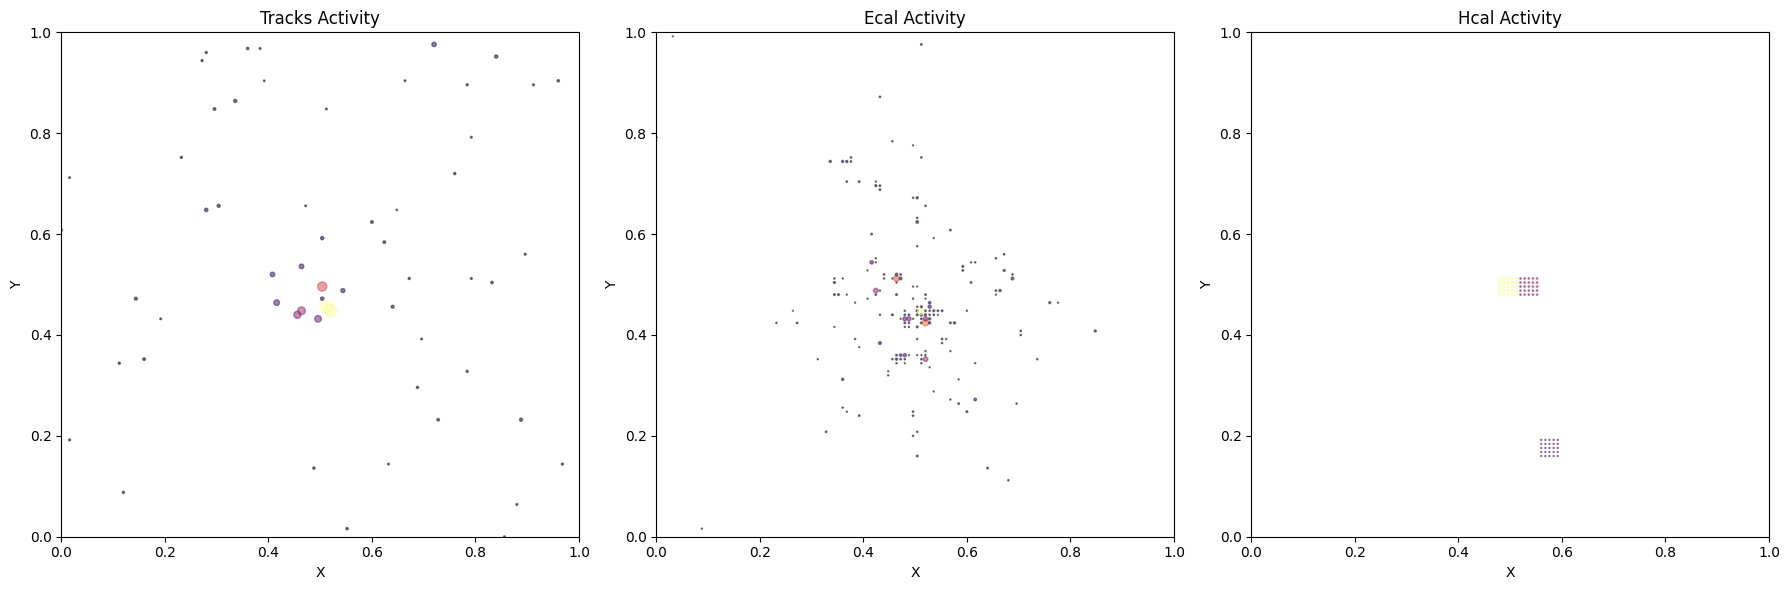

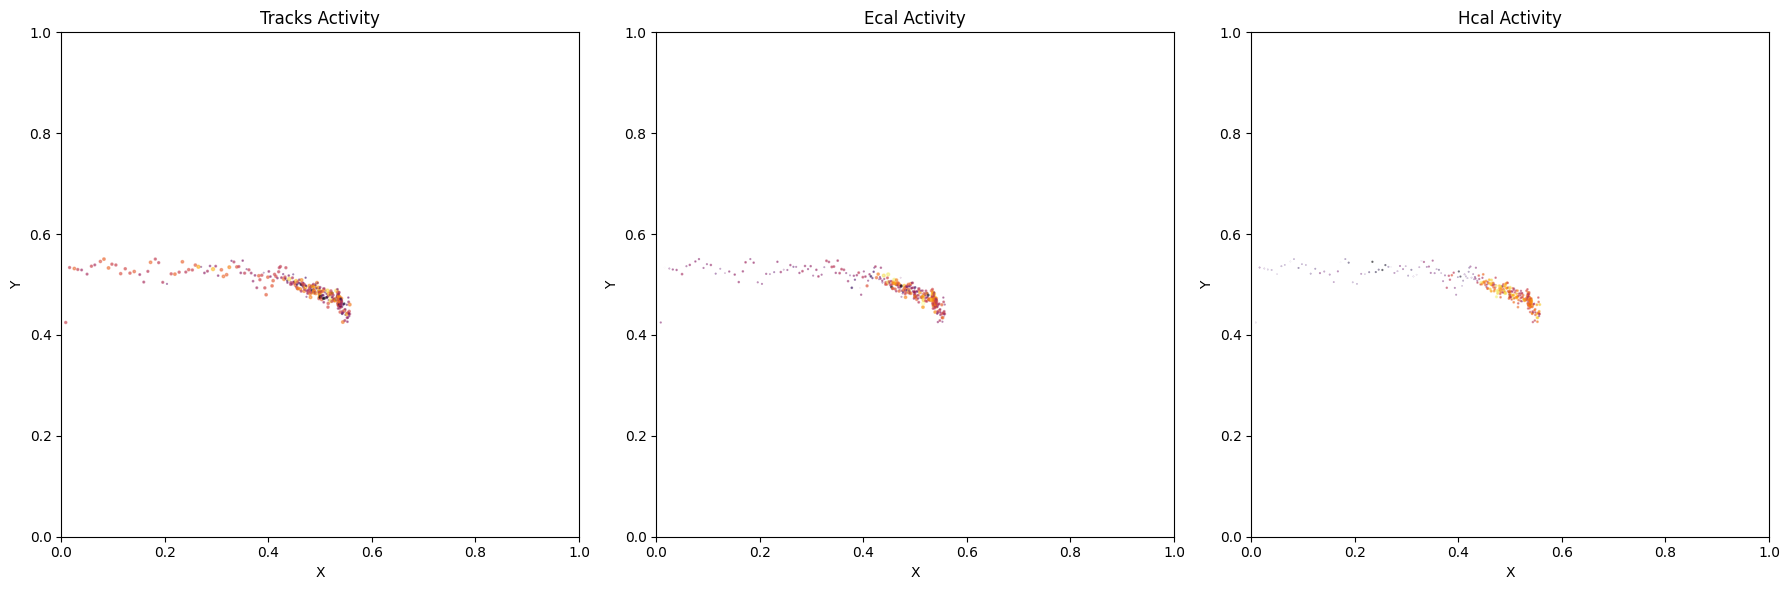

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.01s/it]

SSIM Score: 0.9556882381439209


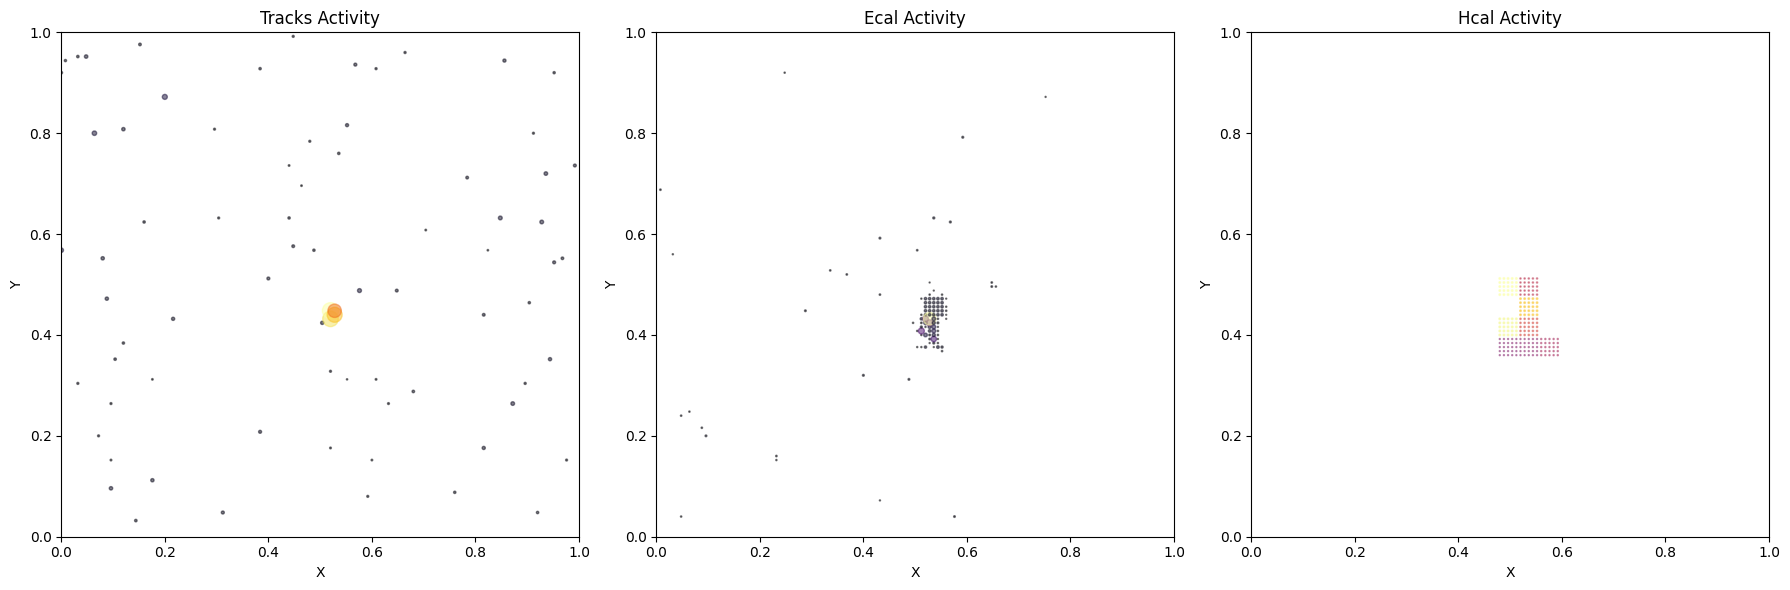

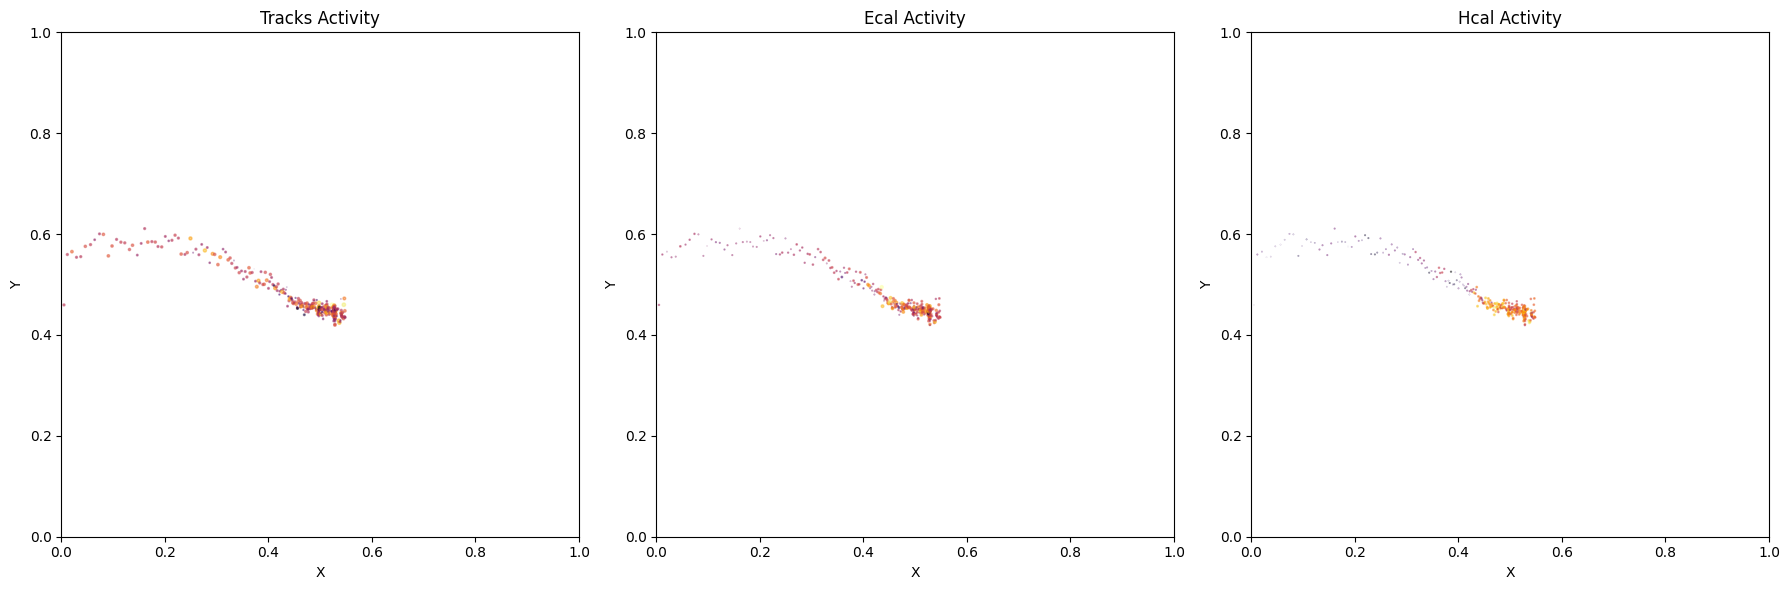

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.03s/it]

SSIM Score: 0.9610778093338013


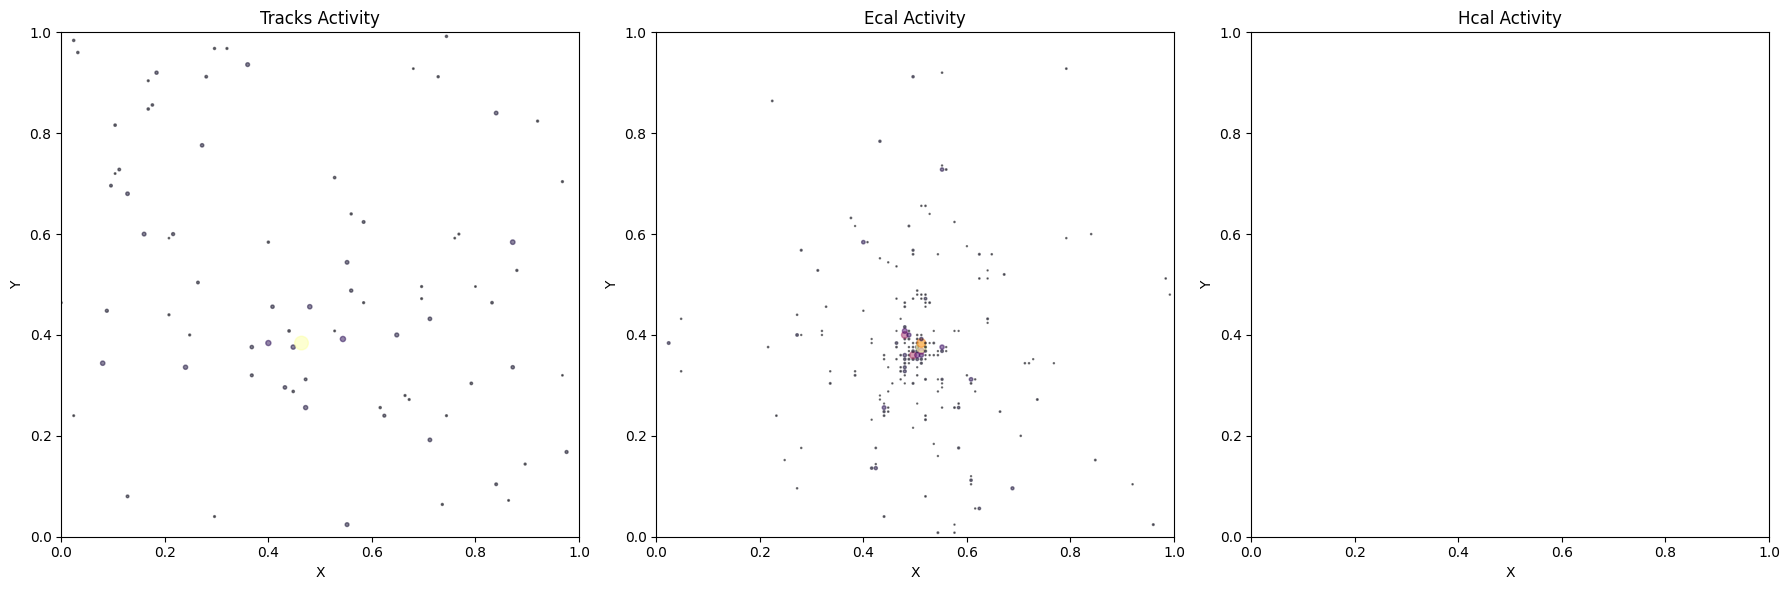

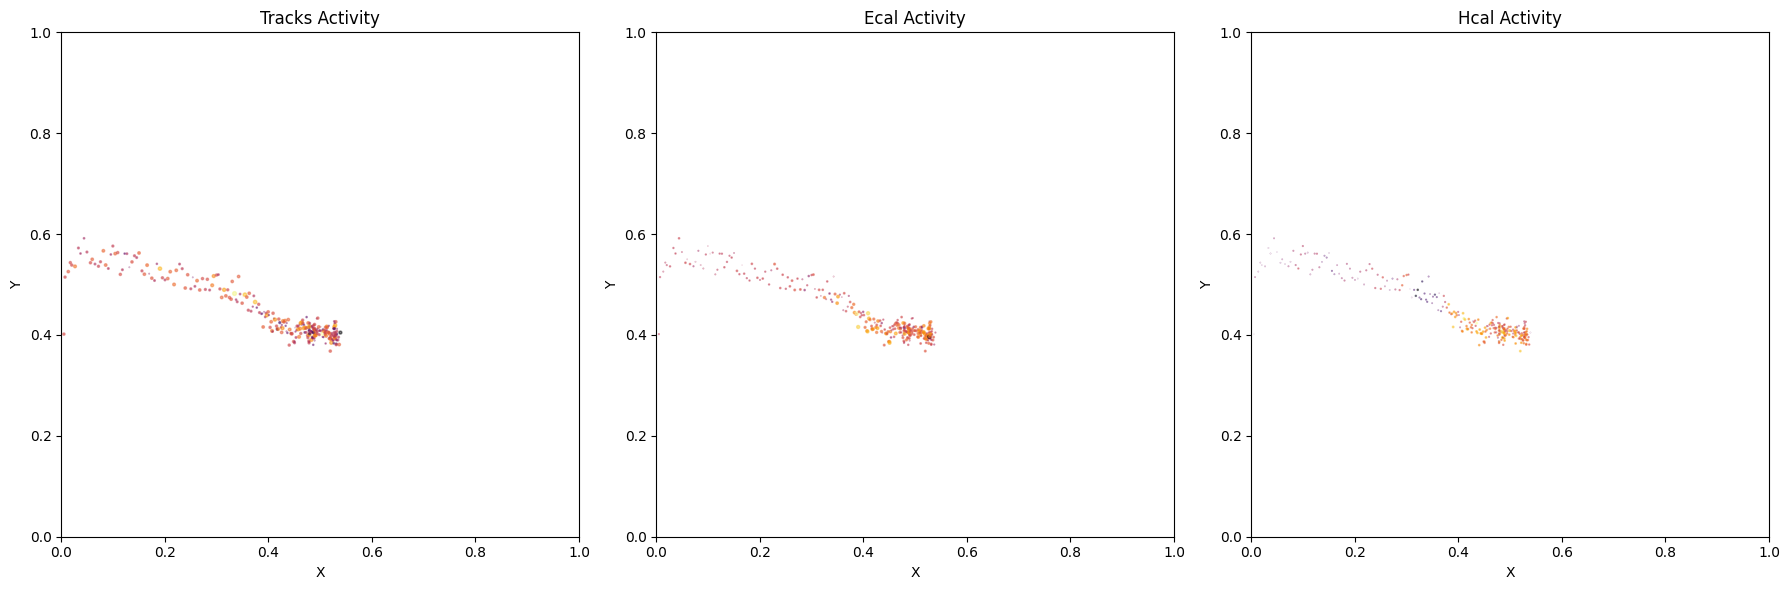

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.21s/it]

SSIM Score: 0.9533557295799255


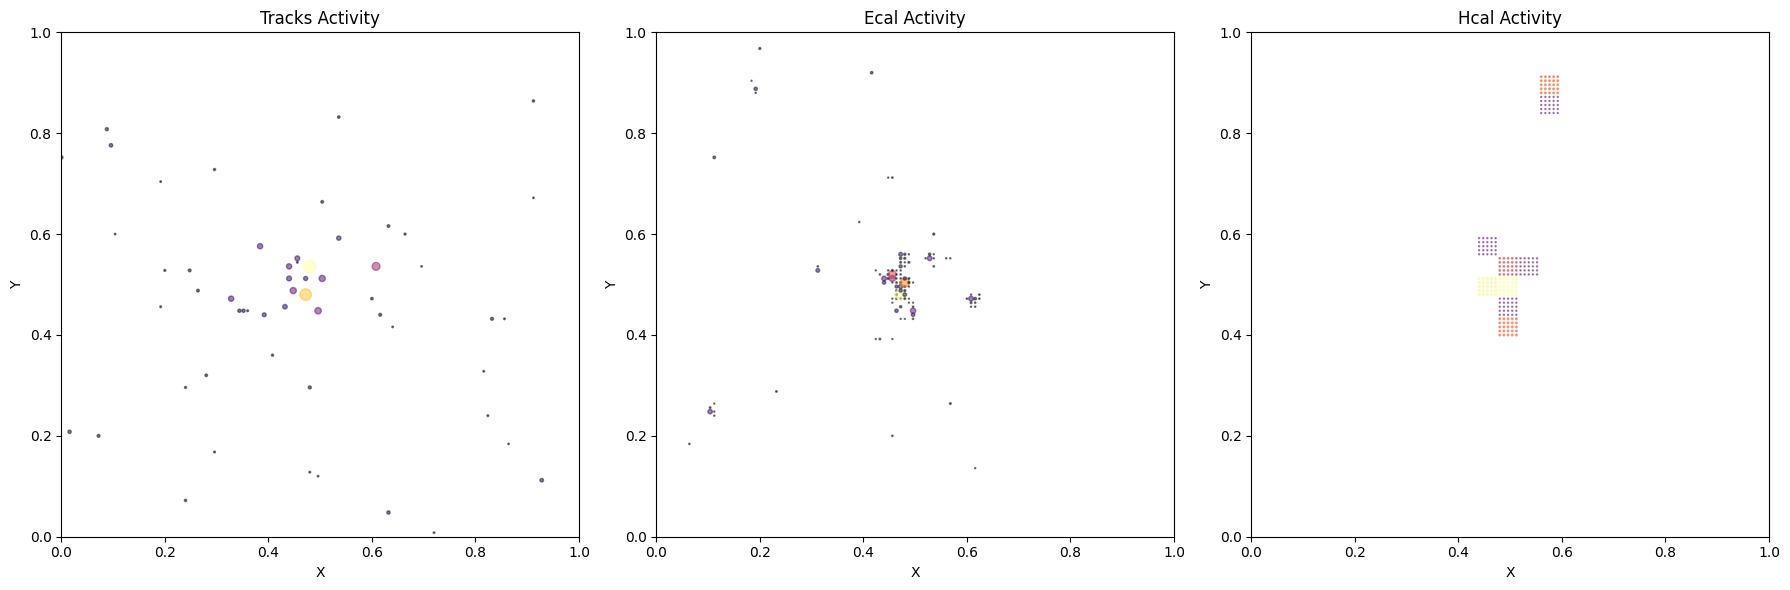

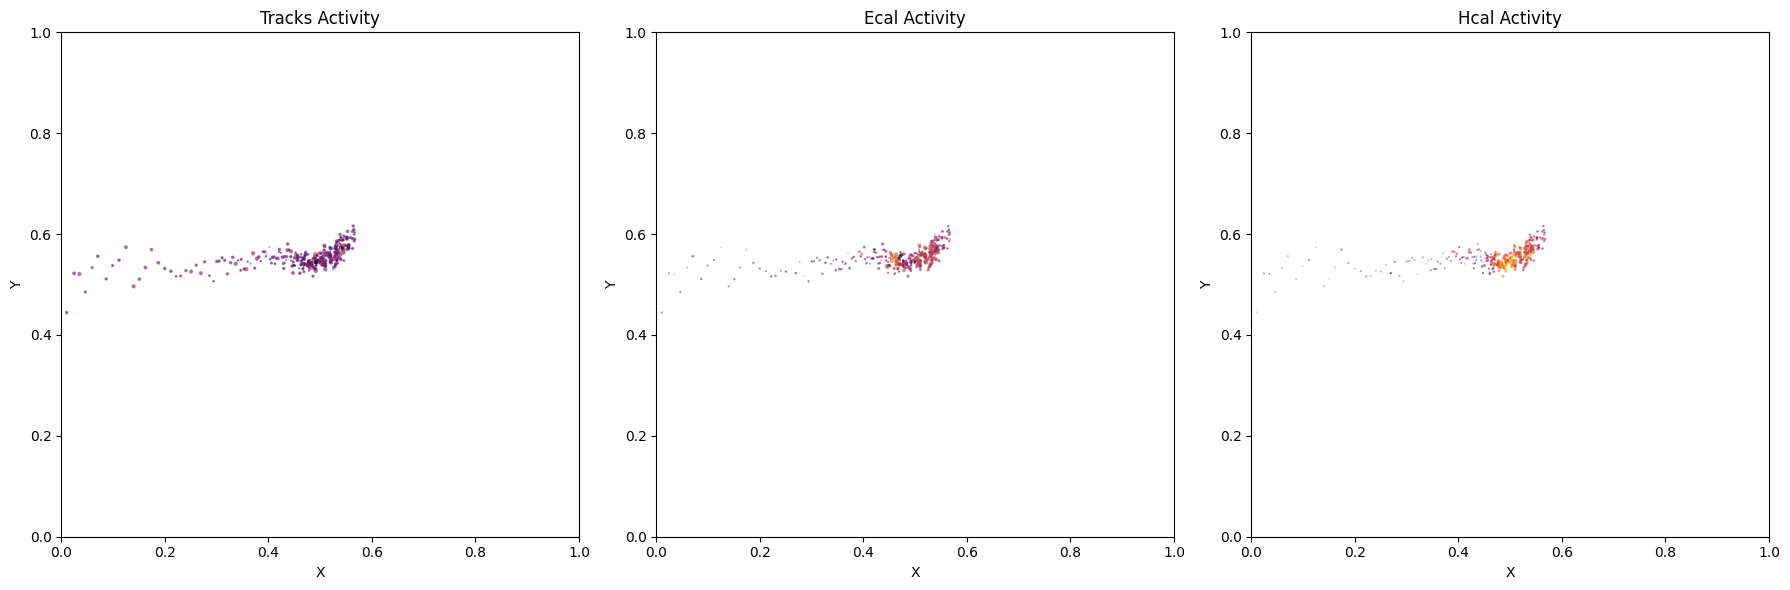

SSIM Score: 0.9513310194015503
Epoch :  40  Train Loss :  0.0084461042174464  Val Loss :  0.009159923996776342


Epoch :  41  Train Loss :  0.008466531698745849  Val Loss :  0.00942206708714366


Epoch :  42  Train Loss :  0.008449674049660325  Val Loss :  0.009602669510059059


Epoch :  43  Train Loss :  0.008426422557626483  Val Loss :  0.009184606606140733


Epoch :  44  Train Loss :  0.00840988868953359  Val Loss :  0.00945672660600394


Epoch :  45  Train Loss :  0.008444719004145364  Val Loss :  0.009671390289440751


Epoch :  46  Train Loss :  0.008448507139694151  Val Loss :  0.009033823967911303


Training:  51%|█████     | 285/563 [00:06<00:06, 42.27it/s, loss=0.00944]

In [ ]:
model = GAE(5, 8)
#model = nn.DataParallel(model)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
val_losses = []
for epoch in range(50):
    train_loss = train()
    train_losses.append(train_loss)
    if (epoch + 1) % 10  == 0:
        val_loss = inference(model, test_loader, device, True)
    else : 
        val_loss = inference(model, test_loader, device)
    val_losses.append(val_loss)
    print("Epoch : ", epoch + 1, " Train Loss : ", train_loss, " Val Loss : ", val_loss)

In [48]:
val_losses[-1] # previously recorded mse loss on validation set

0.009607707150280476

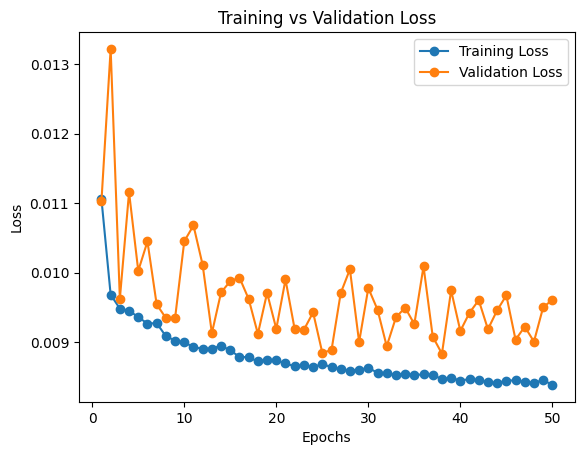

In [43]:
# training and validation curves
epochs = np.arange(1, 51)
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="-")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o", linestyle="-")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Show the plot
plt.show()